In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import seaborn as sns

from statlearning import plot_regressions
from statlearning import plot_histogram
from statlearning import plot_feature_importance

from scipy import stats
from scipy.stats import norm, skew
# import statsmodels.api as sm
# import statsmodels.formula.api as smf


from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import xgboost as xgb

warnings.filterwarnings("ignore")

In [2]:
tic = time.time()

sns.set_context('notebook')
sns.set_style('ticks')
crayon = ['#4E79A7', '#F28E2C', '#E15759', '#76B7B2', '#59A14F',
          '#EDC949', '#AF7AA1', '#FF9DA7', '#9C755F', '#BAB0AB']
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (9, 6)
%matplotlib inline

In [3]:
df = pd.read_csv("NBA_Train.csv")
df

Train_ID     SALARY POSITION                    TEAM  Age  Games  \
0           1   2.489530       PF         Houston Rockets   22     76   
1           2   2.433333       PG               Utah Jazz   24     73   
2           3  20.158622       SF   Oklahoma City Thunder   25     81   
3           4  12.404495       PG         Houston Rockets   26     62   
4           5   1.500000       PG           Brooklyn Nets   21     48   
5           6   2.854940       PF              Miami Heat   33     46   
6           7   1.252440       SF         Detroit Pistons   22     43   
7           8   6.300000       PG           Brooklyn Nets   30     80   
8           9  15.514031       SG    New Orleans Pelicans   25     64   
9          10  12.000000       PG         Toronto Raptors   27     79   
10         11   3.553917       SF         Toronto Raptors   22     81   
11         12   6.270000       SG         Detroit Pistons   26     77   
12         13   4.440000       PF      Washington Wizards   28     69   
13         14  13.000000        C      Washington Wizards   31     53   
14         15   5.746479       SG           Atlanta Hawks   32     71   
15         16  15.851950       PG      Washington Wizards   23     82   
16         17   2.165160        C          Boston Celtics   22     70   
17         18   1.185784       SF           Brooklyn Nets   26     54   
18         19   4.236287       PG  Portland Trail Blazers   23     82   
19         20   9.756250        C           Atlanta Hawks   29     59   
20         21   2.380593       PF           Orlando Magic   24     76   
21         22  22.359364        C         Houston Rockets   28     71   
22         23   7.500000        C       San Antonio Spurs   31     79   
23         24   5.219169       SF      Los Angeles Lakers   28     64   
24         25   4.000000       PF         New York Knicks   22     78   
25         26   6.500000        C         Detroit Pistons   27     53   
26         27   7.448760        C           Chicago Bulls   33     60   
27         28   4.500000       SG           Chicago Bulls   33     82   
28         29   3.333333       PF           Atlanta Hawks   25     80   
29         30  15.592217        C      Los Angeles Lakers   27     81   
..        ...        ...      ...                     ...  ...    ...   
96         97   1.449187       SF        Sacramento Kings   33     56   
97         98   1.320000       SF    New Orleans Pelicans   26     65   
98         99   3.750000       PF         New York Knicks   23     69   
99        100   2.854940       SG           Chicago Bulls   33     73   
100       101   2.399040       PG         Milwaukee Bucks   22     70   
101       102  19.689000       PF     Cleveland Cavaliers   25     77   
102       103  12.403101       SF        Sacramento Kings   27     73   
103       104  13.500000        C       Charlotte Hornets   29     73   
104       105   1.015421       SG        Sacramento Kings   24     80   
105       106   4.500000       SF   Oklahoma City Thunder   25     82   
106       107   5.000000       PF          Boston Celtics   26     64   
107       108   5.613500       SF      Washington Wizards   27     78   
108       109   0.111444        C       Memphis Grizzlies   29     61   
109       110   5.000000       PF       Memphis Grizzlies   35     72   
110       111   2.038206       SF          Boston Celtics   22     62   
111       112  11.370786       PG   Golden State Warriors   25     78   
112       113   2.900000       PF         Toronto Raptors   33     82   
113       114   2.250000       PG           Chicago Bulls   29     72   
114       115   5.675000       SG       Charlotte Hornets   28     79   
115       116  12.000000       PG       Charlotte Hornets   23     73   
116       117   8.229375       SG         Houston Rockets   27     81   
117       118  16.407501       PG     Cleveland Cavaliers   21     71   
118       119   5.158539       SG       Memphis Grizzlies   32 

## Data Preprocessing

### Useless Columns

In [4]:
df.drop(columns="Train_ID", inplace=True)

### Missing value

In [5]:
df.isnull().sum()

SALARY      0
POSITION    0
TEAM        0
Age         0
Games       0
Minutes     0
PER         0
TS          0
ORB         0
DRB         0
TRB         0
AST         0
STL         0
BLK         0
TOV         0
USG         0
ORtg        0
DRtg        0
OWS         0
DWS         0
WS          0
dtype: int64

### Outliers

In [6]:
def _scatter(df, feature, target):
    """

    """
    # plt.figure(figsize=(16,8))
    plt.scatter(df[feature], df[target])
    plt.xlabel(feature)
    plt.ylabel(target)

    items = [feature, " vs ", target]
    title = ''.join(items)
    plt.title(title)


def subplot_scatter(df, target):
    """
    Plot scatter figures of each column in the dataFrame. 
    Args:
        df: pandas.DataFrame 
            DataFrame input.

        target: pandas.Series()
            Target column.


    """

    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns.drop(target))
    for i, col in enumerate(df.columns.drop(target)):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        _scatter(df, col, target)


def subplot_box(df):
    """

    """

    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        sns.boxplot(x=df[col])


def zscore_drop_missing(df, col_list, THRESHOLD=3):
    """
    
    """
    for col in col_list:
        z = np.abs(stats.zscore(df[col]))
        df = df[(z < THRESHOLD)]

    df.index = range(len(df))
    return df




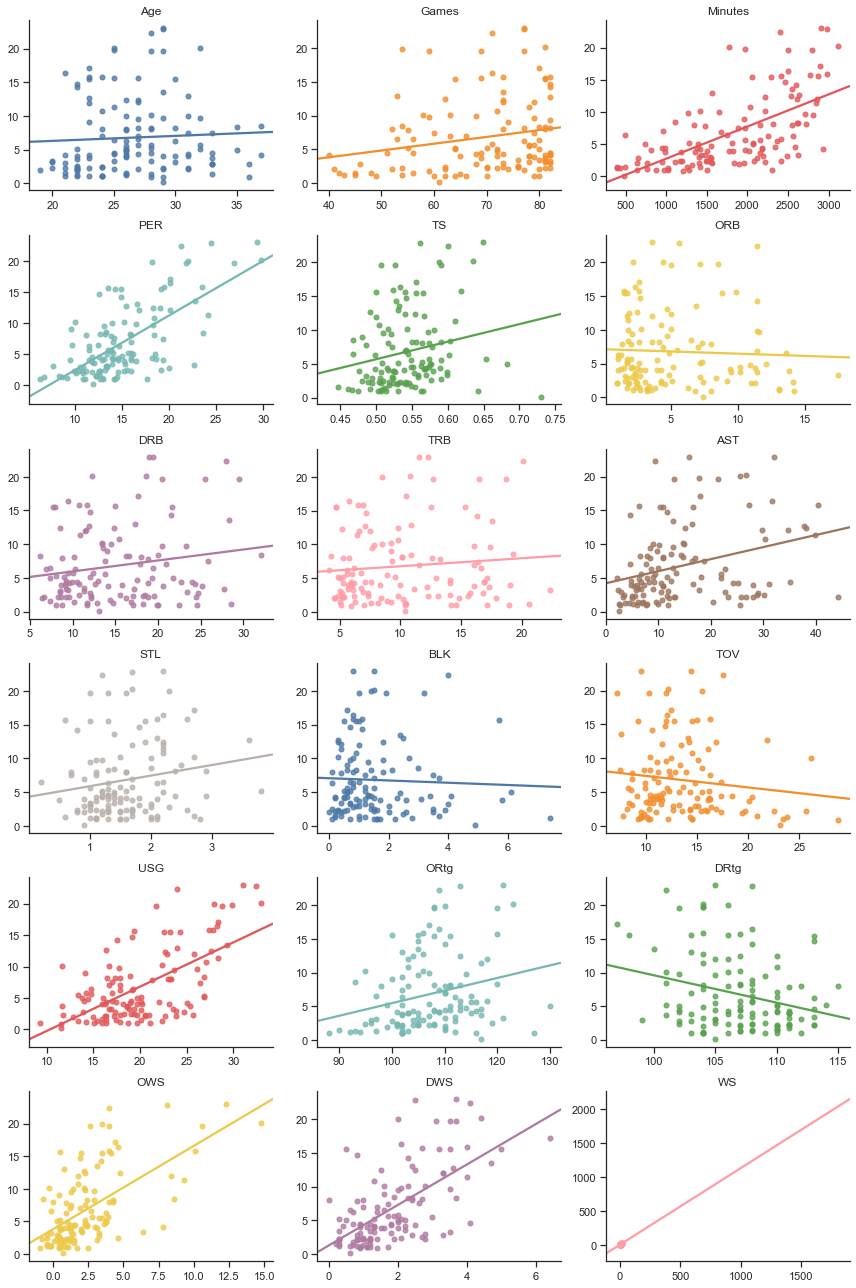

In [7]:
col_category = ["POSITION", "TEAM"]
col_number = df.columns.drop(["TEAM", "POSITION","SALARY"])
col_numbers = df.columns.drop(["TEAM", "POSITION"])

# subplot_scatter(df, "SALARY")

with sns.color_palette(crayon):
    plot_regressions(df[col_number], df["SALARY"])
    plt.show()

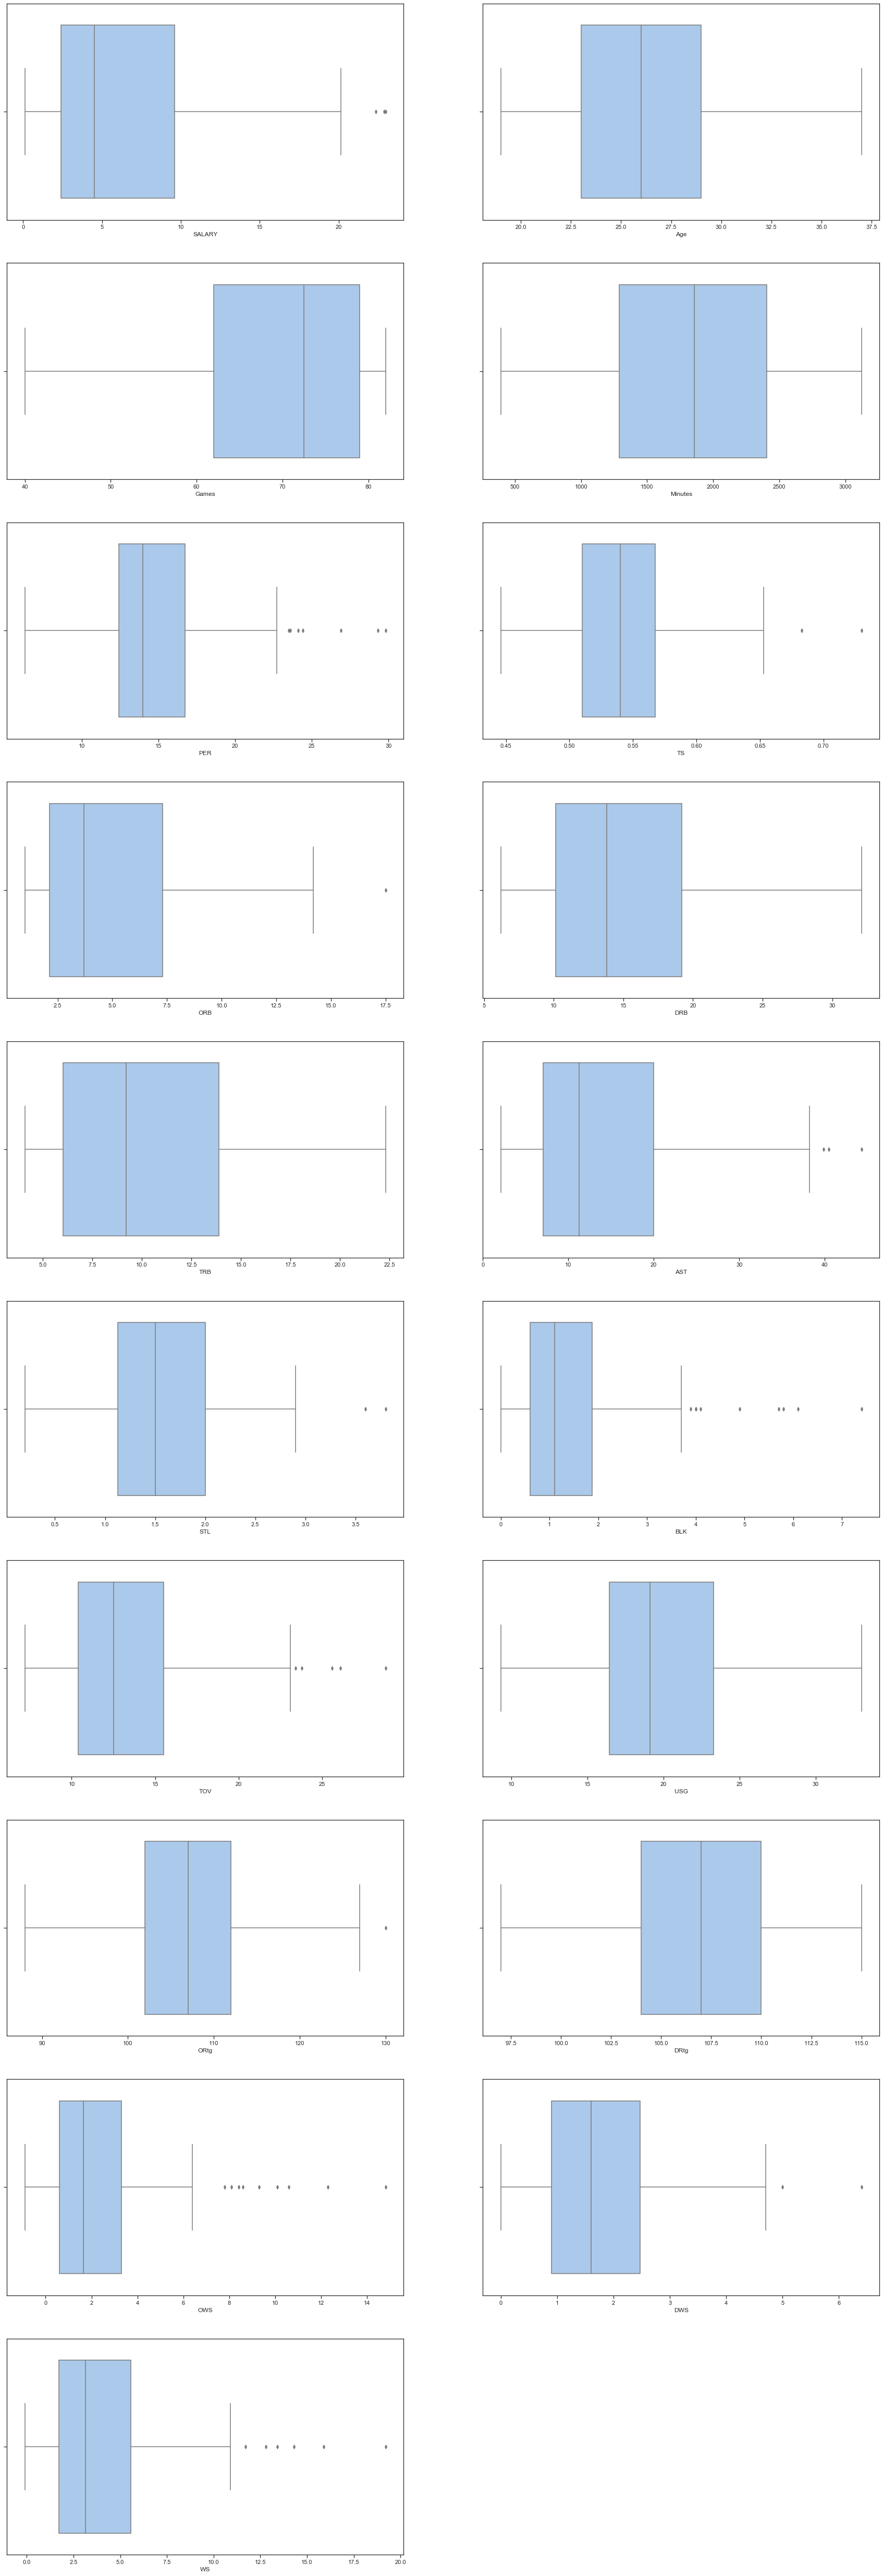

In [8]:
subplot_box(df[col_numbers])

In [9]:
#"SALARY"
df = zscore_drop_missing(df, col_numbers, THRESHOLD=3.7)

In [10]:
df

SALARY POSITION                    TEAM  Age  Games  Minutes   PER  \
0     2.489530       PF         Houston Rockets   22     76     2078  19.1   
1     2.433333       PG               Utah Jazz   24     73     1490  13.2   
2    12.404495       PG         Houston Rockets   26     62     2222  19.0   
3     1.500000       PG           Brooklyn Nets   21     48      489   8.3   
4     2.854940       PF              Miami Heat   33     46      653  10.5   
5     1.252440       SF         Detroit Pistons   22     43      395   6.7   
6     6.300000       PG           Brooklyn Nets   30     80     2252  11.5   
7    15.514031       SG    New Orleans Pelicans   25     64     2057  14.9   
8    12.000000       PG         Toronto Raptors   27     79     2862  20.1   
9     3.553917       SF         Toronto Raptors   22     81     2159  12.0   
10    6.270000       SG         Detroit Pistons   26     77     2556  14.7   
11    4.440000       PF      Washington Wizards   28     69     1376  18.2   
12   13.000000        C      Washington Wizards   31     53     1560  16.6   
13    5.746479       SG           Atlanta Hawks   32     71     2408  13.5   
14   15.851950       PG      Washington Wizards   23     82     2980  19.5   
15    2.165160        C          Boston Celtics   22     70     1400  15.2   
16    1.185784       SF           Brooklyn Nets   26     54      768   9.1   
17    4.236287       PG  Portland Trail Blazers   23     82     2937  18.6   
18    9.756250        C           Atlanta Hawks   29     59     1271  16.5   
19    2.380593       PF           Orlando Magic   24     76     1174   9.9   
20   22.359364        C         Houston Rockets   28     71     2396  21.3   
21    7.500000        C       San Antonio Spurs   31     79     1974  14.1   
22    5.219169       SF      Los Angeles Lakers   28     64     1810  16.0   
23    4.000000       PF         New York Knicks   22     78     1820  11.5   
24    6.500000        C         Detroit Pistons   27     53      491   9.7   
25    7.448760        C           Chicago Bulls   33     60     1884  19.3   
26    4.500000       SG           Chicago Bulls   33     82     2584  12.6   
27    3.333333       PF           Atlanta Hawks   25     80     1482  15.3   
28   15.592217        C      Los Angeles Lakers   27     81     2409  13.5   
29    2.144772       PG      Philadelphia 76ers   22     54     1564  12.6   
..         ...      ...                     ...  ...    ...      ...   ...   
90    2.814000       SG       San Antonio Spurs   36     68     1550  20.0   
91    1.449187       SF        Sacramento Kings   33     56     1419  12.2   
92    1.320000       SF    New Orleans Pelicans   26     65     1020   8.6   
93    3.750000       PF         New York Knicks   23     69     1188  16.5   
94    2.854940       SG           Chicago Bulls   33     73     2116  10.8   
95    2.399040       PG         Milwaukee Bucks   22     70     2414  15.5   
96   19.689000       PF     Cleveland Cavaliers   25     77     2797  26.9   
97   12.403101       SF        Sacramento Kings   27     73     2531  18.3   
98   13.500000        C       Charlotte Hornets   29     73     2553  22.7   
99    1.015421       SG        Sacramento Kings   24     80     2309  10.9   
100   4.500000       SF   Oklahoma City Thunder   25     82     2337  11.8   
101   5.000000       PF          Boston Celtics   26     64      741  13.4   
102   5.613500       SF      Washington Wizards   27     78     2157  11.5   
103   5.000000       PF       Memphis Grizzlies   35     72     1396  18.5   
104   2.038206       SF          Boston Celtics   22     62      764  10.1   
105  11.370786       PG   Golden State Warriors   25     78     2846  24.1   
106   2.900000       PF         Toronto Raptors   33     82     1399  13.4   
107   2.250000       PG           Chicago Bulls   29     72     1557  12.5   
108   5.675000       SG       Charlotte Hornets   28     79     1973  13.8   
109  12.000000       PG       

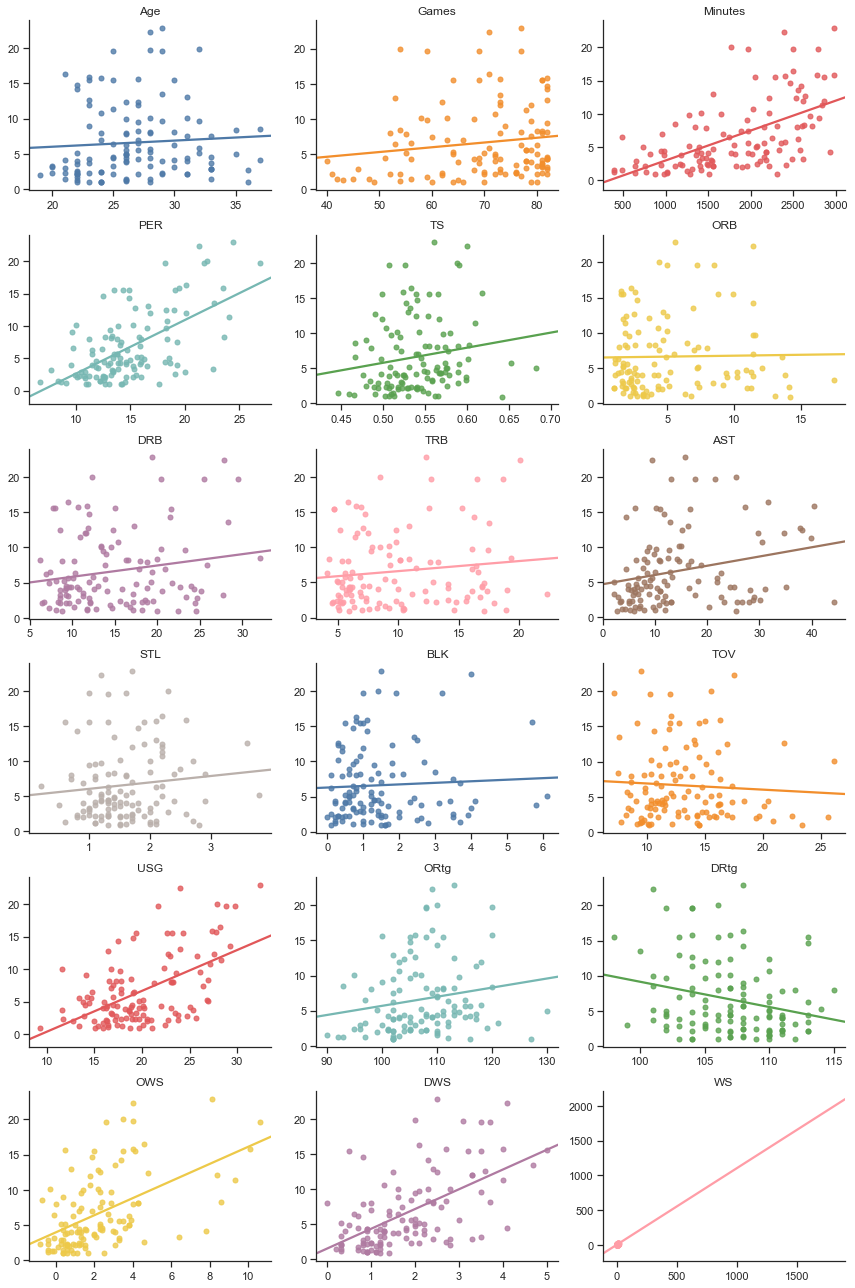

In [11]:
# subplot_scatter(df, "SALARY")
with sns.color_palette(crayon):
    plot_regressions(df[col_number], df["SALARY"])
    plt.show()

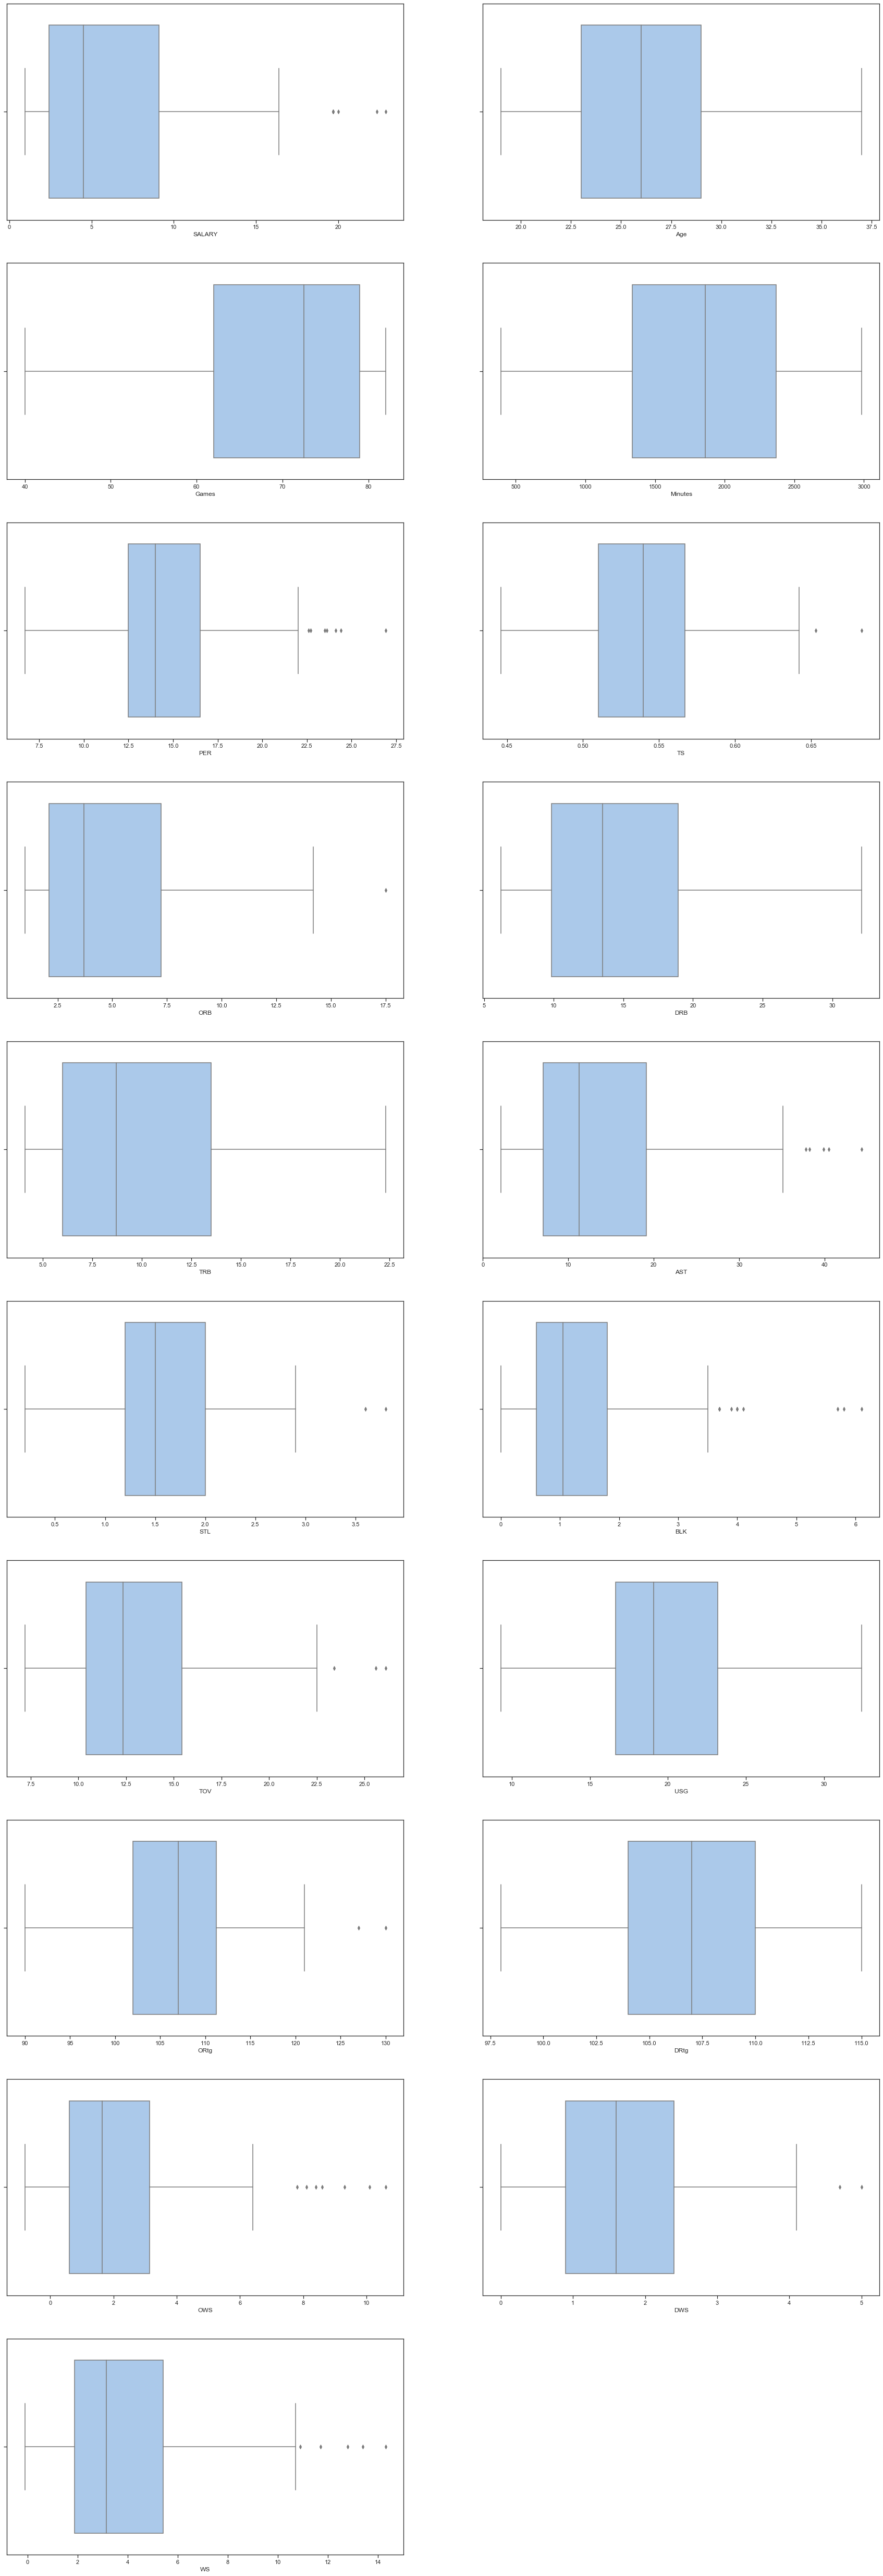

In [12]:
subplot_box(df[col_numbers])

### Normalization

In [13]:
normalized  = lambda x: (x - x.min()) * (1-0) / (x.max()-x.min())

normalized(df[col_number])

Age     Games   Minutes       PER        TS       ORB       DRB  \
0    0.166667  0.857143  0.650830  0.613861  0.552743  0.496970  0.474903   
1    0.277778  0.785714  0.423716  0.321782  0.270042  0.036364  0.173745   
2    0.388889  0.523810  0.706450  0.608911  0.455696  0.054545  0.088803   
3    0.111111  0.190476  0.037080  0.079208  0.000000  0.096970  0.042471   
4    0.777778  0.142857  0.100425  0.188119  0.324895  0.448485  0.714286   
5    0.166667  0.071429  0.000772  0.000000  0.059072  0.133333  0.212355   
6    0.611111  0.952381  0.718038  0.237624  0.219409  0.006061  0.158301   
7    0.333333  0.571429  0.642719  0.405941  0.396624  0.042424  0.057915   
8    0.444444  0.928571  0.953650  0.663366  0.510549  0.157576  0.204633   
9    0.166667  0.976190  0.682117  0.262376  0.451477  0.078788  0.196911   
10   0.388889  0.880952  0.835458  0.396040  0.654008  0.018182  0.027027   
11   0.500000  0.690476  0.379683  0.569307  0.447257  0.557576  0.687259   
12   0.666667  0.309524  0.450753  0.490099  0.354430  0.224242  0.428571   
13   0.722222  0.738095  0.778293  0.336634  0.873418  0.006061  0.239382   
14   0.222222  1.000000  0.999228  0.633663  0.329114  0.030303  0.212355   
15   0.166667  0.714286  0.388953  0.420792  0.421941  0.606061  0.486486   
16   0.388889  0.333333  0.144844  0.118812  0.084388  0.133333  0.463320   
17   0.222222  1.000000  0.982619  0.589109  0.514768  0.018182  0.115830   
18   0.555556  0.452381  0.339127  0.485149  0.531646  0.630303  0.552124   
19   0.277778  0.857143  0.301661  0.158416  0.181435  0.248485  0.513514   
20   0.500000  0.738095  0.773658  0.722772  0.649789  0.630303  0.837838   
21   0.666667  0.928571  0.610660  0.366337  0.556962  0.206061  0.293436   
22   0.500000  0.571429  0.547316  0.460396  0.497890  0.042424  0.073359   
23   0.166667  0.904762  0.551178  0.237624  0.329114  0.200000  0.370656   
24   0.444444  0.309524  0.037852  0.148515  0.088608  0.763636  0.509653   
25   0.777778  0.476190  0.575898  0.623762  0.320675  0.363636  0.760618   
26   0.777778  1.000000  0.846273  0.292079  0.434599  0.066667  0.262548   
27   0.333333  0.952381  0.420626  0.425743  0.476793  0.236364  0.424710   
28   0.444444  0.976190  0.778679  0.336634  0.223629  0.539394  0.339768   
29   0.166667  0.333333  0.452298  0.292079  0.202532  0.000000  0.131274   
..        ...       ...       ...       ...       ...       ...       ...   
90   0.944444  0.666667  0.446891  0.658416  0.607595  0.078788  0.223938   
91   0.777778  0.380952  0.396292  0.272277  0.278481  0.042424  0.409266   
92   0.388889  0.595238  0.242178  0.094059  0.189873  0.169697  0.254826   
93   0.222222  0.690476  0.307068  0.485149  0.337553  0.515152  0.733591   
94   0.777778  0.785714  0.665508  0.202970  0.202532  0.042424  0.088803   
95   0.166667  0.714286  0.780610  0.435644  0.143460  0.200000  0.362934   
96   0.333333  0.880952  0.928544  1.000000  0.611814  0.454545  0.899614   
97   0.444444  0.785714  0.825801  0.574257  0.396624  0.242424  0.332046   
98   0.555556  0.785714  0.834299  0.792079  0.362869  0.357576  0.853282   
99   0.277778  0.952381  0.740054  0.207921  0.354430  0.103030  0.212355   
100  0.333333  1.000000  0.750869  0.252475  0.540084  0.254545  0.115830   
101  0.388889  0.571429  0.134415  0.331683  0.552743  0.375758  0.505792   
102  0.444444  0.904762  0.681344  0.237624  0.611814  0.060606  0.150579   
103  0.888889  0.761905  0.387408  0.584158  1.000000  0.672727  0.598456   
104  0.166667  0.523810  0.143299  0.168317  0.400844  0.200000  0.227799   
105  0.333333  0.904762  0.947470  0.861386  0.691983  0.048485  0.181467   
106  0.777778  1.000000  0.388567  0.331683  0.248945  0.375758  0.664093   
107  0.555556  0.761905  0.449594  0.287129  0.303797  0.127273  0.019305   
108  0.500000  0.928571  0.610274  0.351485  0.540084  0.042424  0.127413   
109  0.222222  0.785714  0.857860  0.500000  0.223629  0.042424  0.208494   
110  0

## Exploratory data analysis (EDA)

In [61]:
def get_status(x):
    return pd.DataFrame([x.count(), x.mean(),  x.min(), x.quantile(.25), x.quantile(.5), x.quantile(.75), x.max(), x.median(), x.mad(), x.var(), x.std(), x.skew(), x.kurt(), ],
                        index=['count', 'mean', 'min', '25%', '50%', '75%', 'max', 'median', 'mad', 'var', 'std', 'skew', 'kurt', ]).round(3)


def plot_distributed(series):
    
    sns.distplot(series, fit=norm, bins=10, color='cornflowerblue')
    (mu, sigma) = norm.fit(series)
    plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=${:.2f})'.format(
        mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution of '+series.name)

def subplot_distributed(df):
    """

    """
    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        
        plot_distributed(df[col])

def plot_prob(series):
    stats.probplot(series,plot=plt)
    

def subplot_prob(df):
    """

    """
    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        plot_prob(df[col])
        


### Target Variable

In [62]:
get_status(df["SALARY"])

0
count   120.000
mean      6.603
min       0.947
25%       2.425
50%       4.500
75%       9.104
max      22.875
median    4.500
mad       4.222
var      27.947
std       5.286
skew      1.218
kurt      0.781

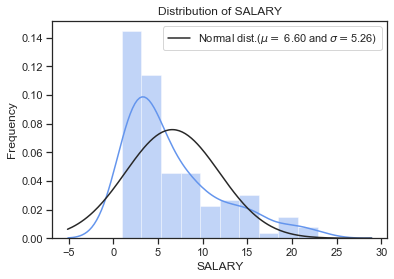

In [16]:
plot_distributed(df["SALARY"])

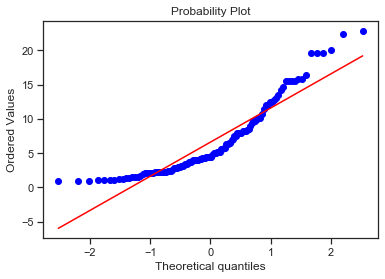

In [17]:
plot_prob(df["SALARY"])

In [18]:
get_status(df["SALARY"]**(1/3))

0
count   120.000
mean      1.750
std       0.480
min       0.982
25%       1.343
50%       1.651
75%       2.088
max       2.839
median    1.651
mad       0.399
var       0.230
std       0.480
skew      0.380
kurt     -0.720

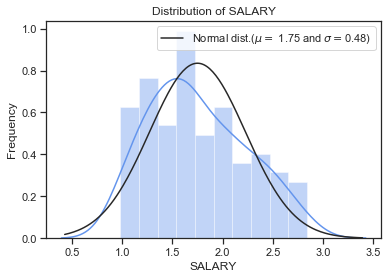

In [19]:
plot_distributed(df["SALARY"]**(1/3))

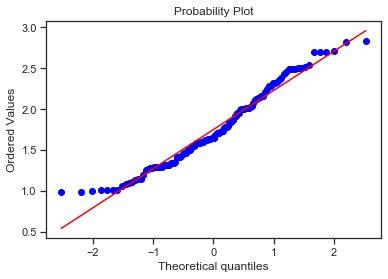

In [20]:
plot_prob(df["SALARY"]**(1/3))

### Numerical Variables

In [21]:
df_eda = normalized(df[col_number])
get_status(df_eda)

Age    Games  Minutes      PER       TS      ORB      DRB  \
count   120.000  120.000  120.000  120.000  120.000  120.000  120.000   
mean      0.429    0.704    0.546    0.401    0.397    0.249    0.336   
std       0.229    0.270    0.260    0.191    0.173    0.231    0.232   
min       0.000    0.000    0.000    0.000    0.000    0.000    0.000   
25%       0.222    0.524    0.365    0.286    0.270    0.067    0.140   
50%       0.389    0.774    0.566    0.361    0.395    0.164    0.282   
75%       0.556    0.929    0.763    0.486    0.511    0.377    0.491   
max       1.000    1.000    1.000    1.000    1.000    1.000    1.000   
median    0.389    0.774    0.566    0.361    0.395    0.164    0.282   
mad       0.185    0.224    0.222    0.148    0.137    0.190    0.194   
var       0.052    0.073    0.067    0.037    0.030    0.054    0.054   
std       0.229    0.270    0.260    0.191    0.173    0.231    0.232   
skew      0.455   -0.822   -0.184    0.720    0.465    1.070    0.686   
kurt     -0.383   -0.303   -0.925    0.428    0.690    0.197   -0.349   

            TRB      AST      STL      BLK      TOV      USG     ORtg  \
count   120.000  120.000  120.000  120.000  120.000  120.000  120.000   
mean      0.324    0.292    0.385    0.238    0.318    0.459    0.428   
std       0.254    0.230    0.171    0.203    0.201    0.200    0.179   
min       0.000    0.000    0.000    0.000    0.000    0.000    0.000   
25%       0.104    0.118    0.278    0.098    0.169    0.318    0.300   
50%       0.253    0.217    0.361    0.172    0.272    0.424    0.425   
75%       0.516    0.403    0.500    0.295    0.435    0.602    0.531   
max       1.000    1.000    1.000    1.000    1.000    1.000    1.000   
median    0.253    0.217    0.361    0.172    0.272    0.424    0.425   
mad       0.216    0.184    0.133    0.151    0.158    0.163    0.142   
var       0.065    0.053    0.029    0.041    0.040    0.040    0.032   
std       0.254    0.230    0.171    0.203    0.201    0.200    0.179   
skew      0.678    1.104    0.820    1.593    1.031    0.375    0.291   
kurt     -0.758    0.466    1.211    2.664    1.229   -0.391    0.383   

           DRtg      OWS      DWS       WS  
count   120.000  120.000  120.000  120.000  
mean      0.532    0.263    0.357    0.284  
std       0.213    0.195    0.216    0.202  
min       0.000    0.000    0.000    0.000  
25%       0.353    0.123    0.180    0.137  
50%       0.529    0.215    0.320    0.226  
75%       0.706    0.346    0.480    0.384  
max       1.000    1.000    1.000    1.000  
median    0.529    0.215    0.320    0.226  
mad       0.174    0.142    0.177    0.156  
var       0.045    0.038    0.047    0.041  
std       0.213    0.195    0.216    0.202  
skew     -0.130    1.698    0.718    1.304  
kurt     -0.609    3.441   -0.048    1.873

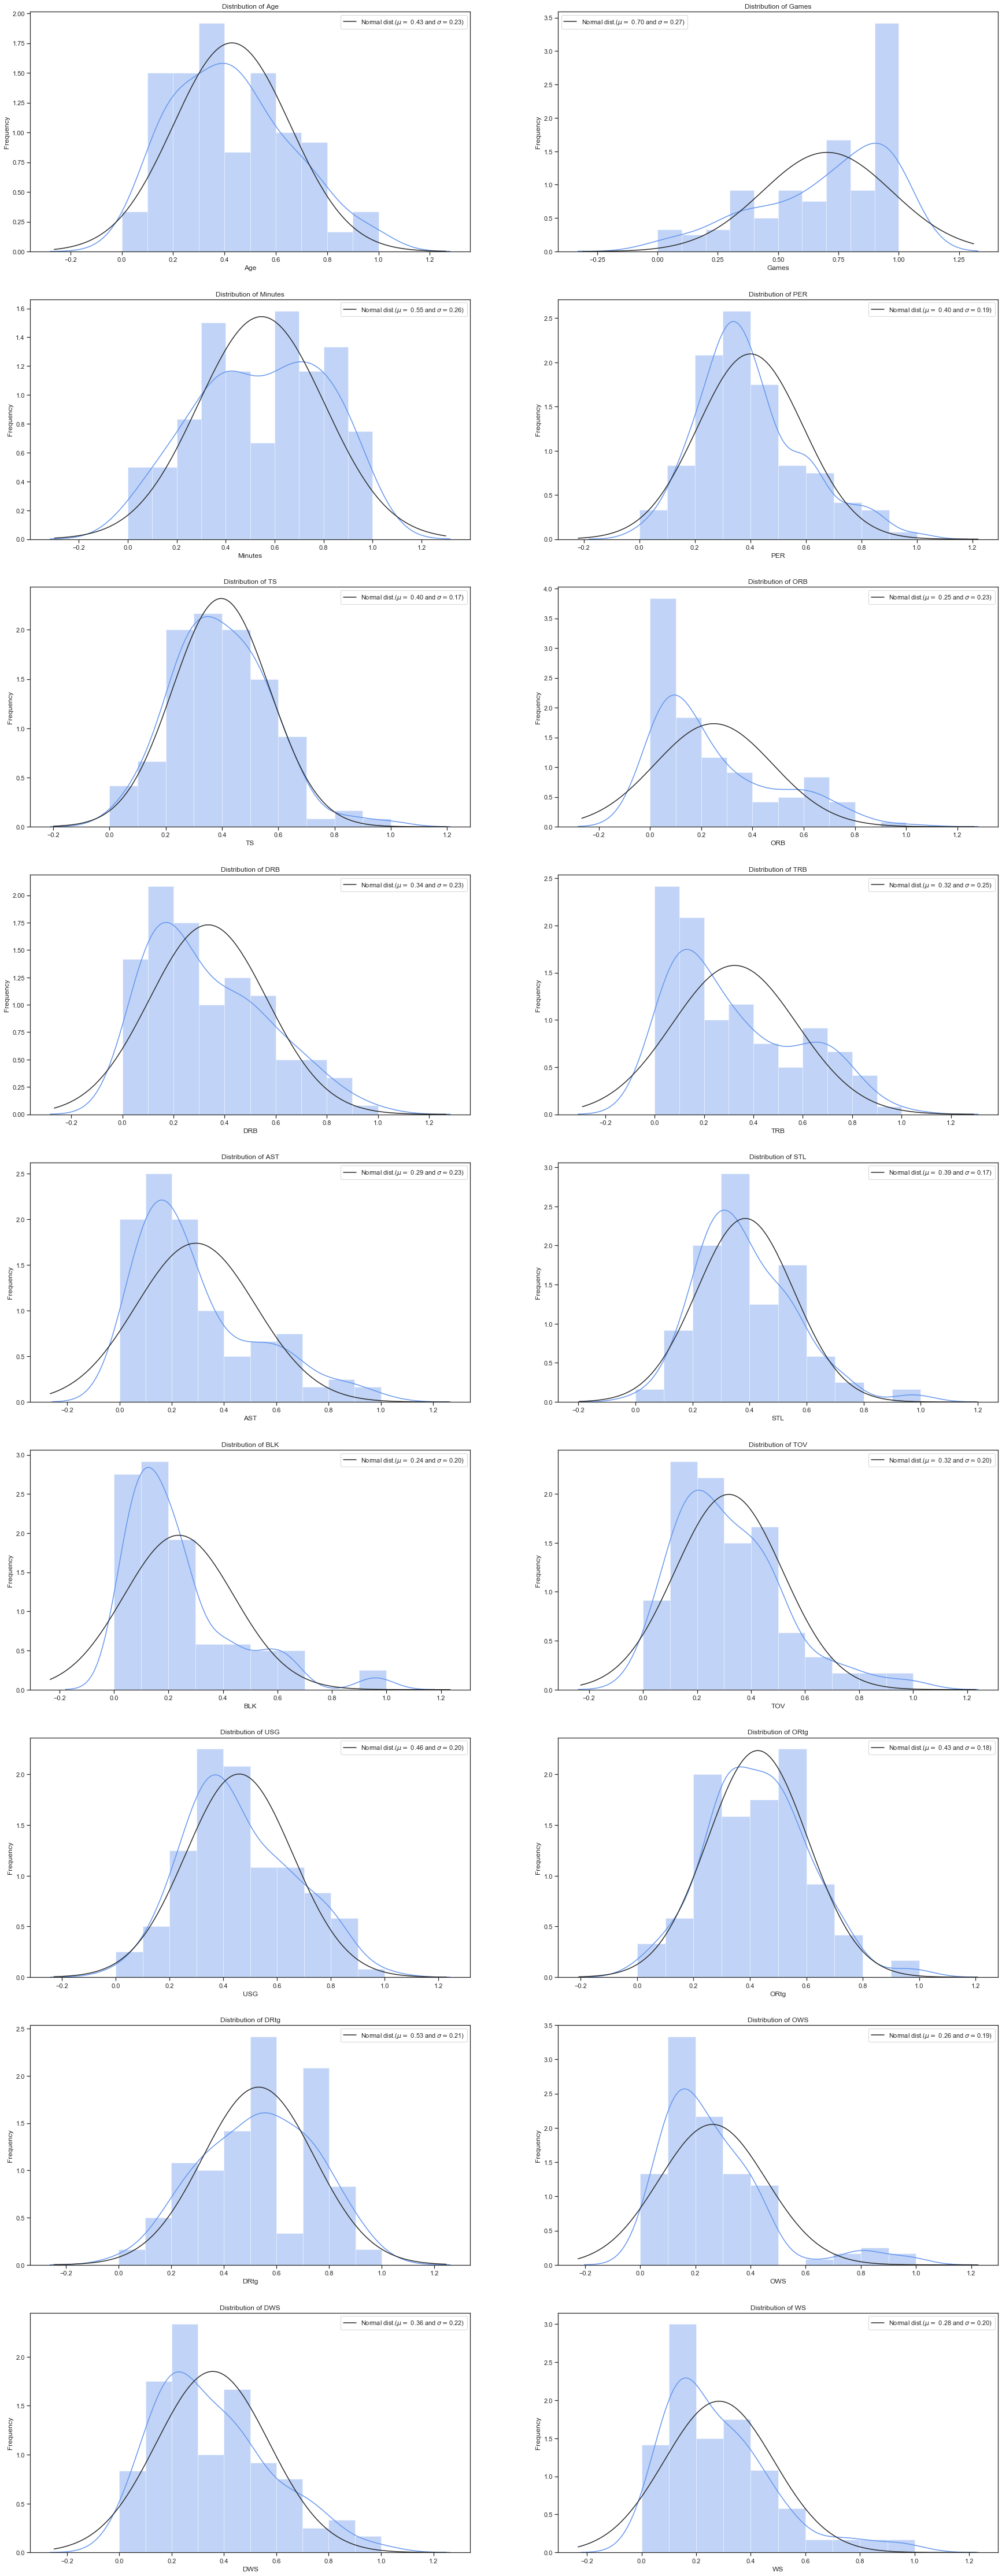

In [22]:
subplot_distributed(df_eda)

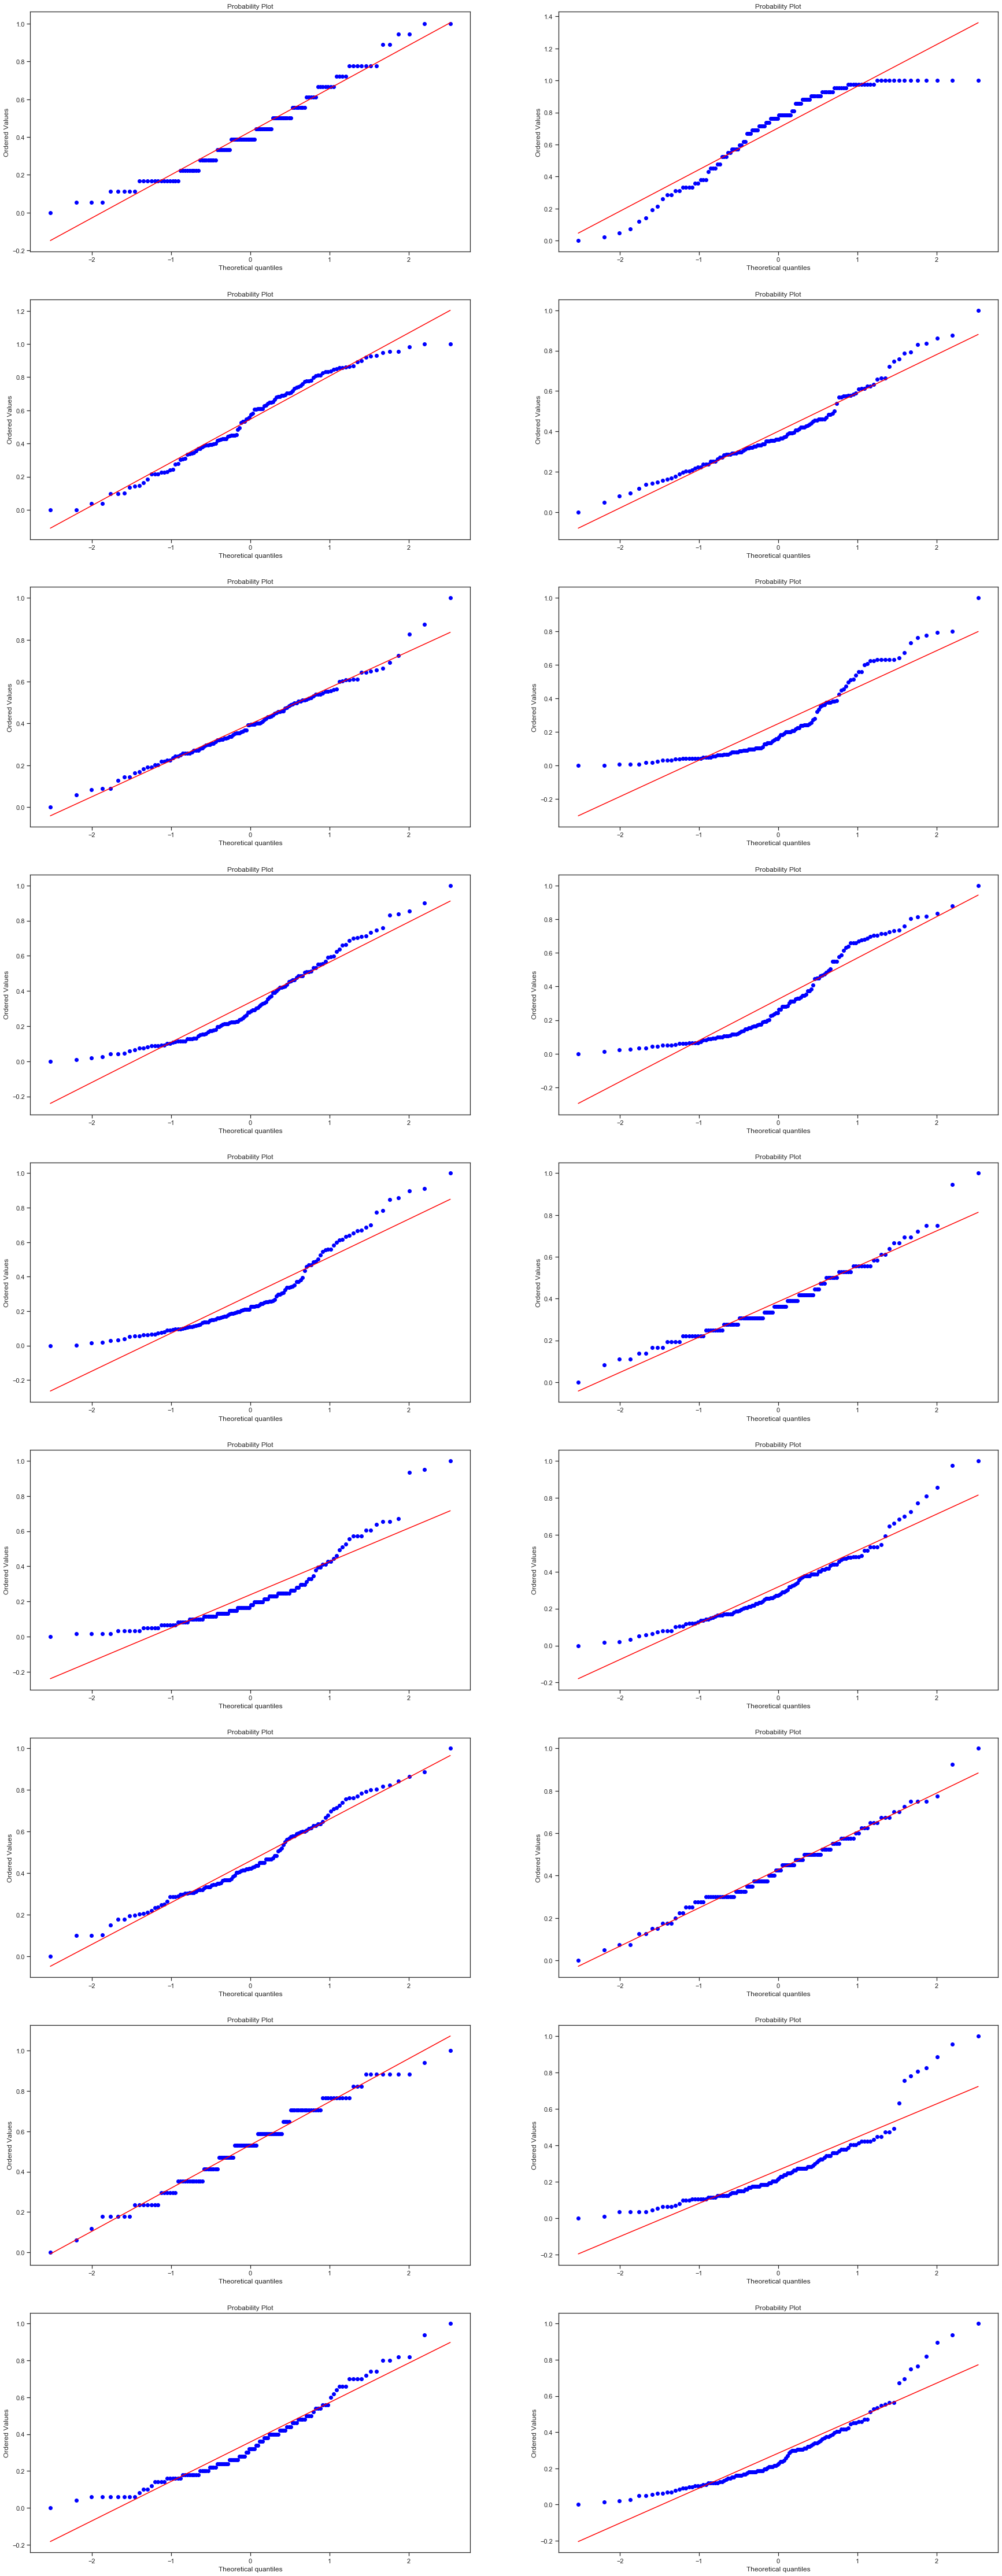

In [23]:
subplot_prob(df_eda)

In [24]:
skew_high_cols = ["BLK", "OWS", "WS"]
for col in skew_high_cols:
    df_eda[col] = df_eda[col] ** (1/3)

skew_medium_cols = ["PER", "TS", "ORB",
                    "DRB", "TRB", "AST", "STL", "TOV", "DWS"]
for col in skew_medium_cols:
    df_eda[col] = np.sqrt(df_eda[col])

skew_low_log = ["Games"]
for col in skew_low_log:
    df_eda[col] = df_eda[col] ** 2

In [25]:
get_status(df_eda)

Age    Games  Minutes      PER       TS      ORB      DRB  \
count   120.000  120.000  120.000  120.000  120.000  120.000  120.000   
mean      0.429    0.567    0.546    0.613    0.612    0.442    0.541   
std       0.229    0.329    0.260    0.158    0.149    0.231    0.210   
min       0.000    0.000    0.000    0.000    0.000    0.000    0.000   
25%       0.222    0.274    0.365    0.535    0.520    0.258    0.374   
50%       0.389    0.599    0.566    0.601    0.628    0.404    0.531   
75%       0.556    0.862    0.763    0.697    0.715    0.614    0.701   
max       1.000    1.000    1.000    1.000    1.000    1.000    1.000   
median    0.389    0.599    0.566    0.601    0.628    0.404    0.531   
mad       0.185    0.286    0.222    0.119    0.115    0.194    0.176   
var       0.052    0.108    0.067    0.025    0.022    0.053    0.044   
std       0.229    0.329    0.260    0.158    0.149    0.231    0.210   
skew      0.455   -0.239   -0.184   -0.312   -0.646    0.387   -0.015   
kurt     -0.383   -1.306   -0.925    1.340    1.875   -0.802   -0.647   

            TRB      AST      STL      BLK      TOV      USG     ORtg  \
count   120.000  120.000  120.000  120.000  120.000  120.000  120.000   
mean      0.520    0.498    0.604    0.572    0.534    0.459    0.428   
std       0.232    0.211    0.143    0.173    0.182    0.200    0.179   
min       0.000    0.000    0.000    0.000    0.000    0.000    0.000   
25%       0.323    0.343    0.527    0.462    0.411    0.318    0.300   
50%       0.503    0.466    0.601    0.556    0.522    0.424    0.425   
75%       0.719    0.635    0.707    0.666    0.660    0.602    0.531   
max       1.000    1.000    1.000    1.000    1.000    1.000    1.000   
median    0.503    0.466    0.601    0.556    0.522    0.424    0.425   
mad       0.199    0.169    0.110    0.135    0.145    0.163    0.142   
var       0.054    0.044    0.020    0.030    0.033    0.040    0.032   
std       0.232    0.211    0.143    0.173    0.182    0.200    0.179   
skew      0.144    0.319   -0.339    0.044    0.019    0.375    0.291   
kurt     -1.069   -0.386    2.105    0.404    0.202   -0.391    0.383   

           DRtg      OWS      DWS       WS  
count   120.000  120.000  120.000  120.000  
mean      0.532    0.603    0.568    0.619  
std       0.213    0.158    0.188    0.162  
min       0.000    0.000    0.000    0.000  
25%       0.353    0.497    0.424    0.516  
50%       0.529    0.599    0.566    0.609  
75%       0.706    0.702    0.693    0.727  
max       1.000    1.000    1.000    1.000  
median    0.529    0.599    0.566    0.609  
mad       0.174    0.121    0.154    0.128  
var       0.045    0.025    0.035    0.026  
std       0.213    0.158    0.188    0.162  
skew     -0.130   -0.186   -0.065   -0.310  
kurt     -0.609    1.512   -0.192    1.111

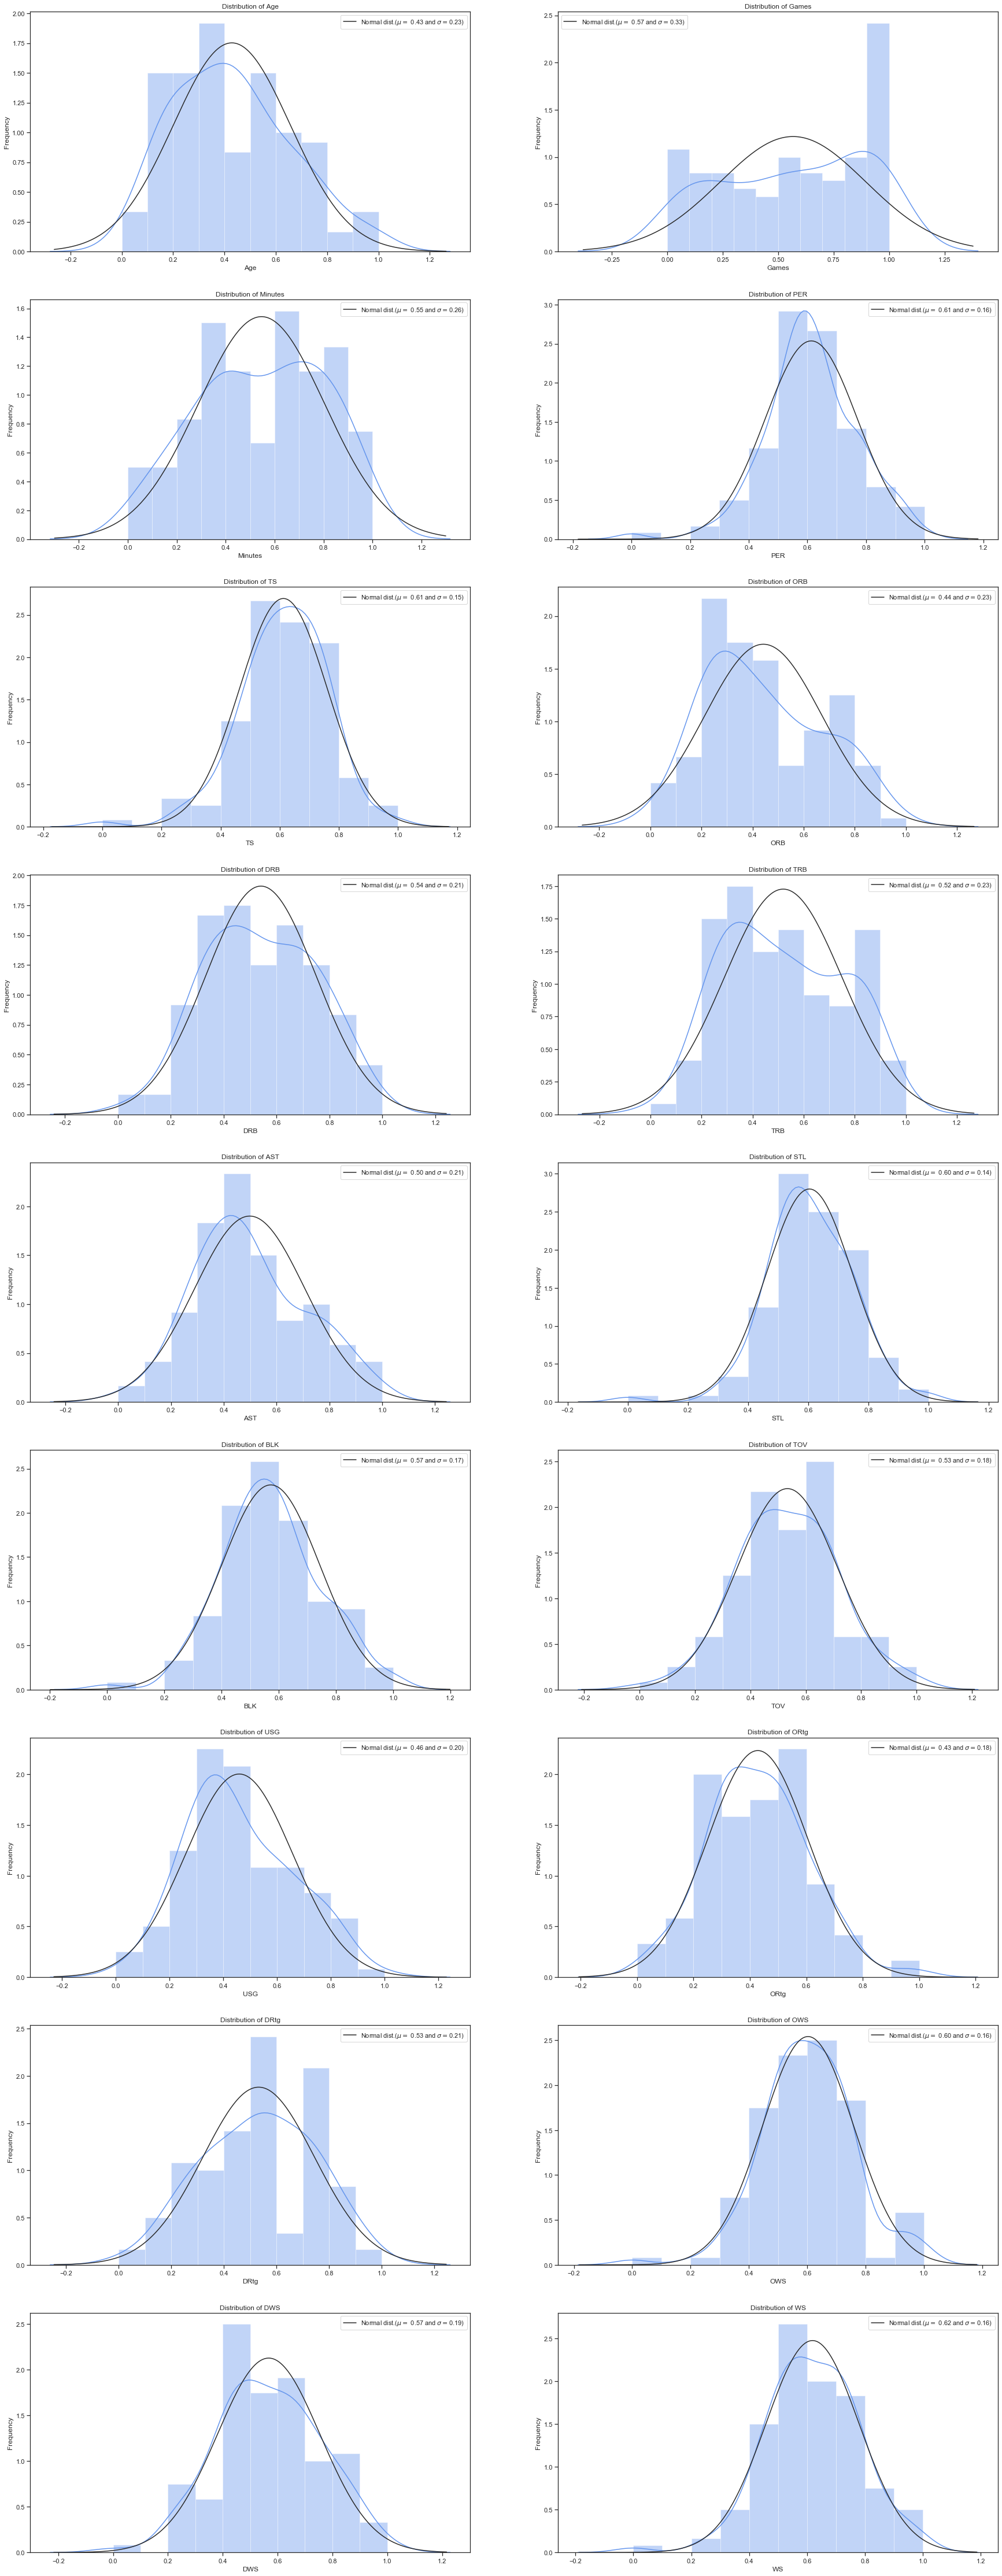

In [26]:
subplot_distributed(df_eda)

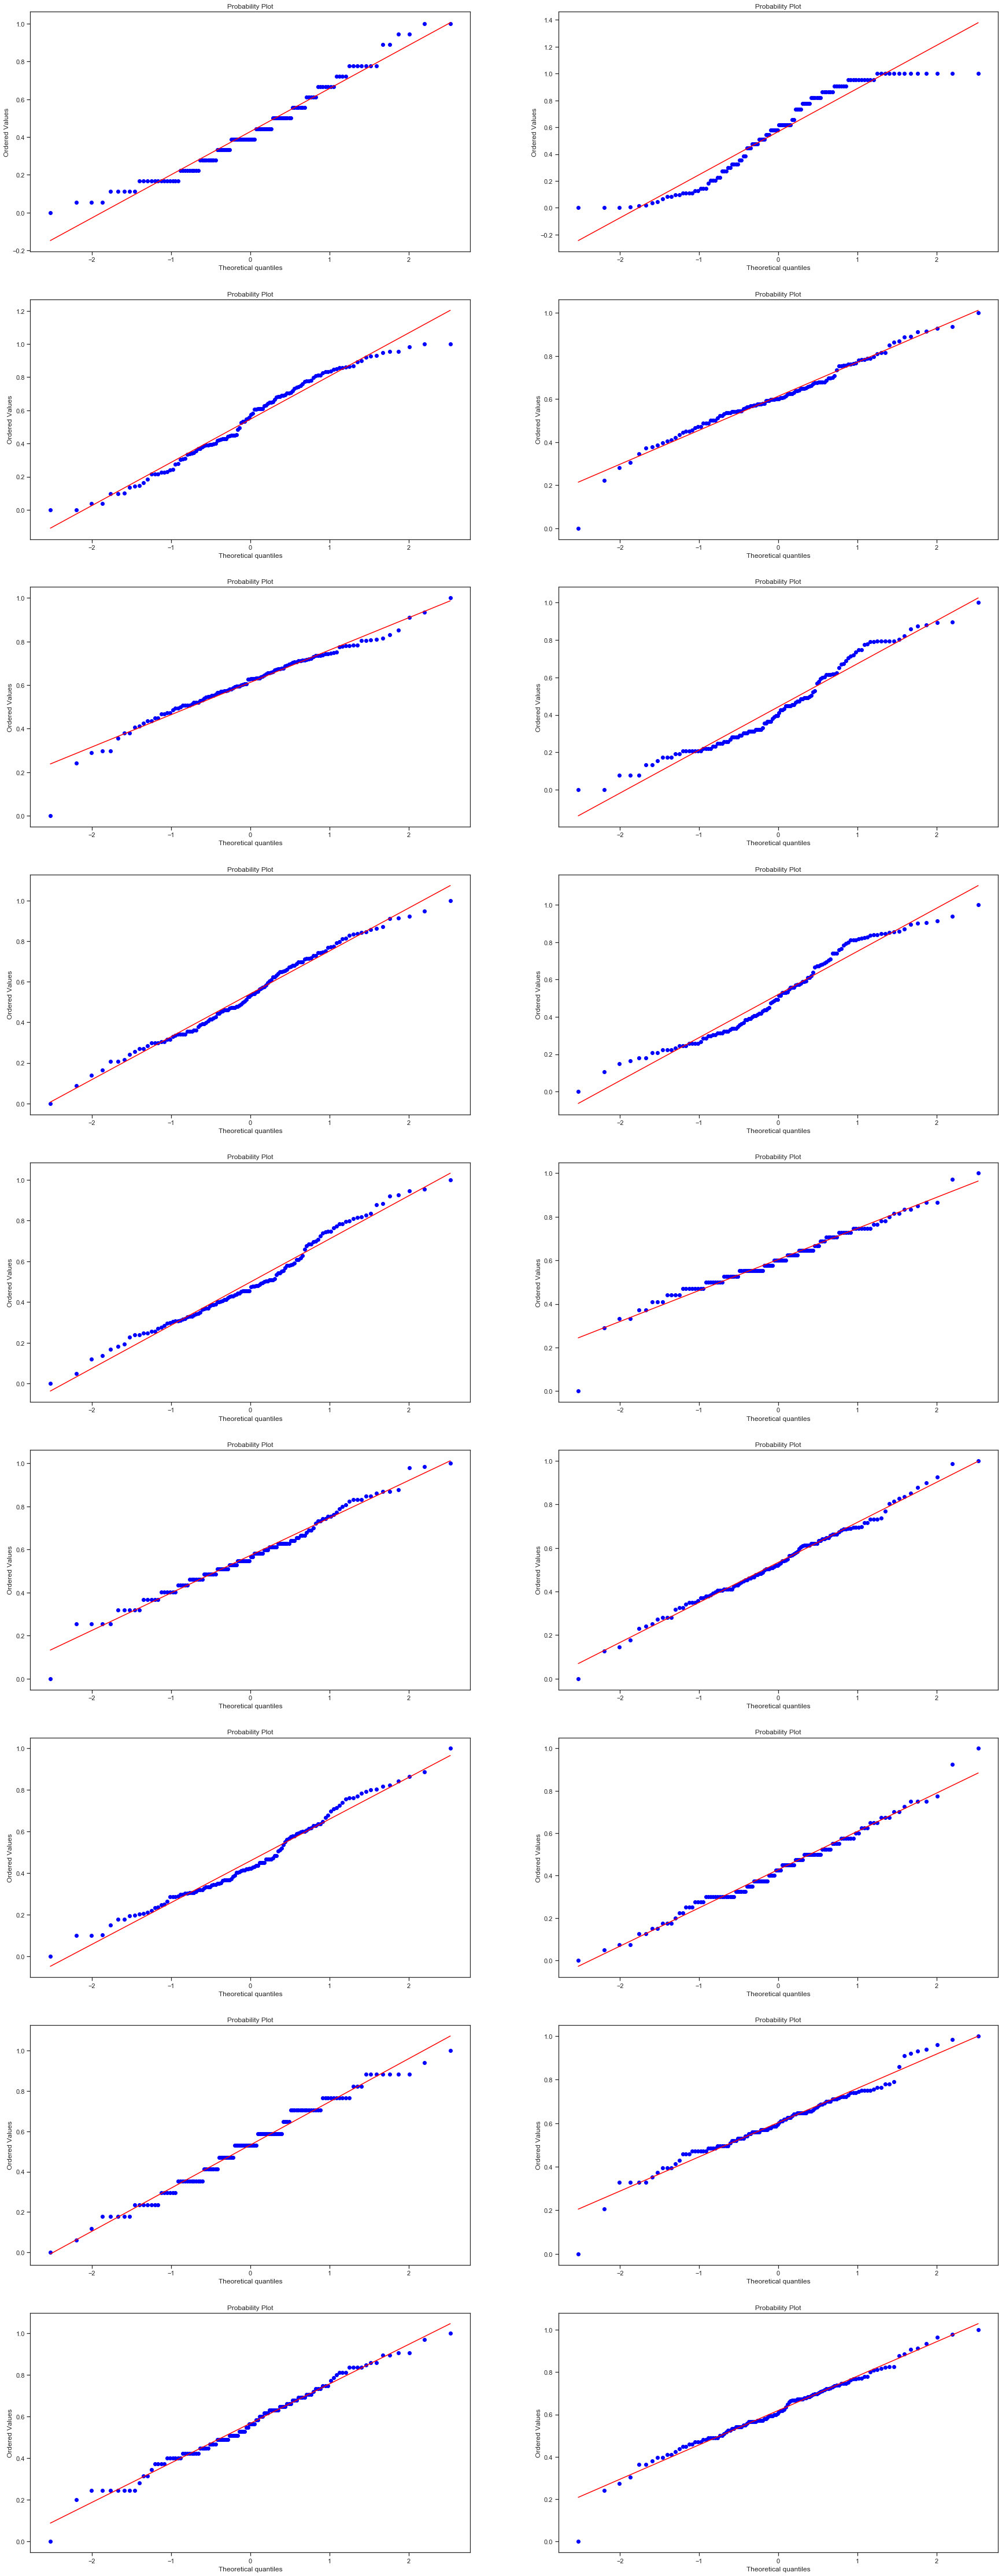

In [27]:
subplot_prob(df_eda)

Text(0.5, 1, 'Correlation Among Variables')

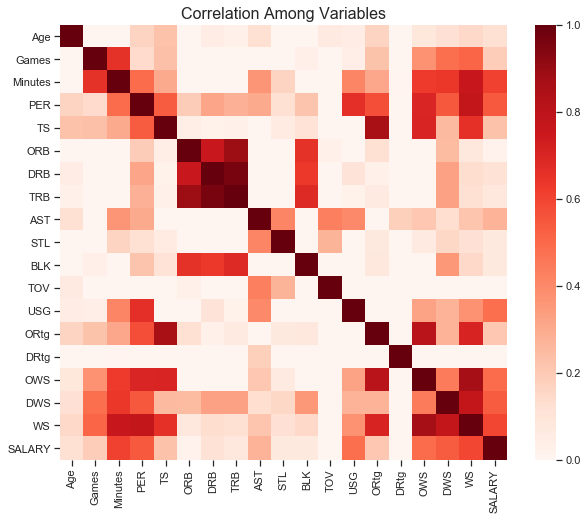

In [28]:
df_eda = pd.concat([df_eda,np.log(df["SALARY"])],axis=1)
plt.figure(figsize = (10,8))
sns.heatmap(df_eda.corr(), vmin = 0, vmax = 1, cmap = 'Reds')
plt.title('Correlation Among Variables', fontsize = 16)

In [29]:
print(abs(df_eda.corr()["SALARY"]).sort_values(ascending=False))

SALARY     1.000000
Minutes    0.612484
WS         0.595247
PER        0.545343
DWS        0.536237
OWS        0.492768
USG        0.486173
AST        0.275239
TS         0.230146
DRtg       0.216809
ORtg       0.208605
Games      0.188585
Age        0.124599
DRB        0.116490
TRB        0.079937
BLK        0.071221
STL        0.070923
TOV        0.061397
ORB        0.019530
Name: SALARY, dtype: float64


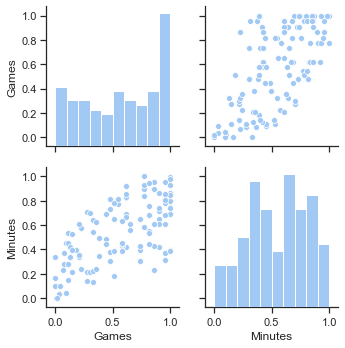

In [30]:
sns.pairplot(df_eda[["Games","Minutes"]])

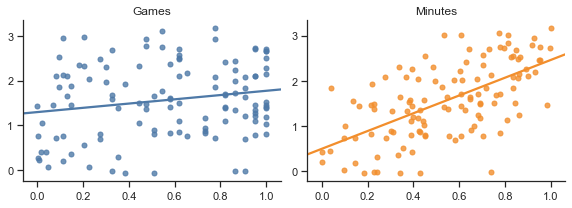

In [31]:
with sns.color_palette(crayon):
    plot_regressions(df_eda[["Games","Minutes"]], df_eda["SALARY"])
    plt.show()

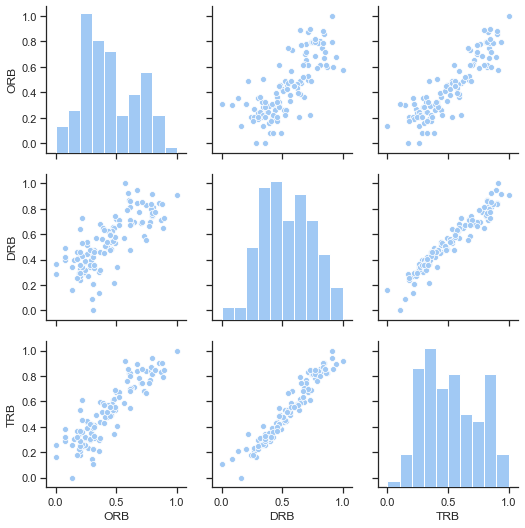

In [32]:
sns.pairplot(df_eda[["ORB","DRB","TRB"]])

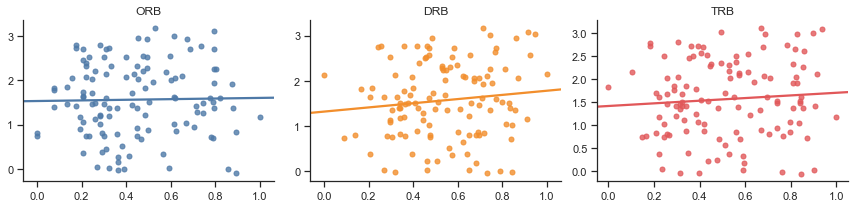

In [33]:
with sns.color_palette(crayon):
    plot_regressions(df_eda[["ORB","DRB","TRB"]], df_eda["SALARY"])
    plt.show()

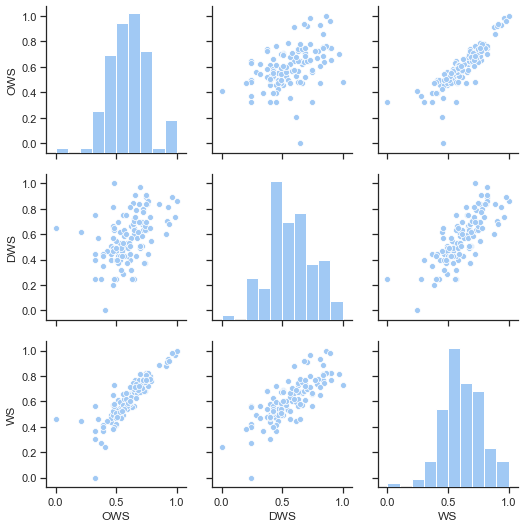

In [34]:
sns.pairplot(df_eda[["OWS","DWS","WS"]])

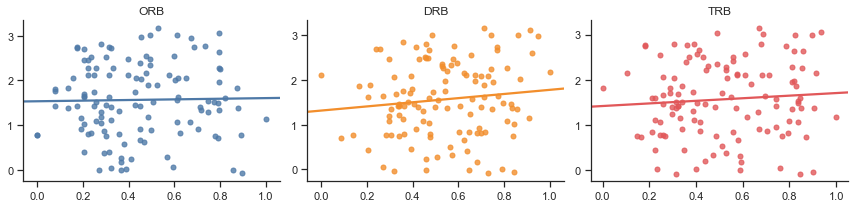

In [35]:
with sns.color_palette(crayon):
    plot_regressions(df_eda[["OWS","DWS","WS"]], df_eda["SALARY"])
    plt.show()

### Category Variables

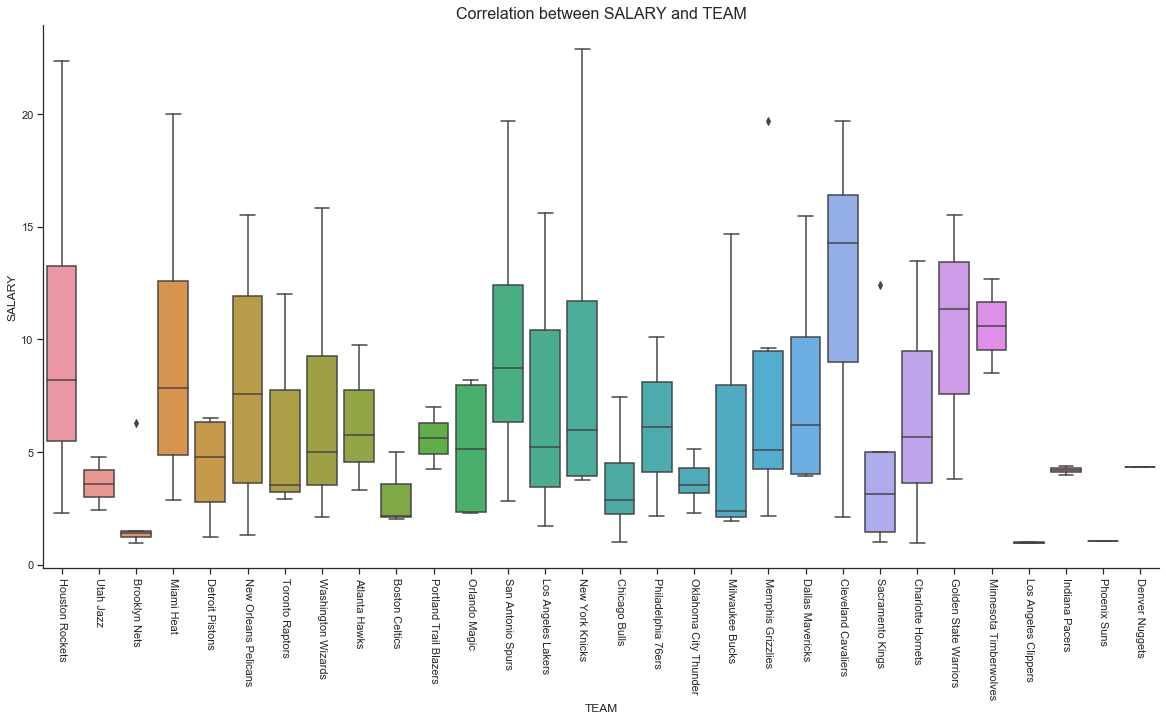

In [36]:
plt.figure(figsize=(20,10))
sns.set_palette("pastel")
sns.boxplot(x = 'TEAM', y = 'SALARY', data = df)
sns.despine()
plt.title('Correlation between SALARY and TEAM', fontsize = 16)
plt.xticks(rotation=270)
plt.show()

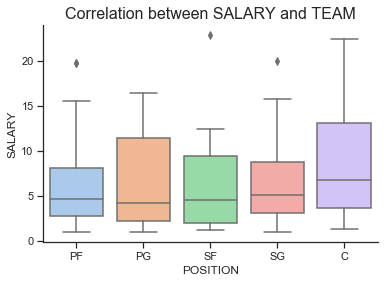

In [37]:
sns.set_palette("pastel")
sns.boxplot(x = 'POSITION', y = 'SALARY', data = df)
sns.despine()
plt.title('Correlation between SALARY and TEAM', fontsize = 16)
plt.show()

In [38]:
def fe_categorical_var(df, cols):
    d = pd.DataFrame()
    for col in cols:
        dummies = pd.get_dummies(
            df[col], prefix_sep="_", drop_first=True, prefix=col)
        #df.drop(columns=col, inplace=True)
        d = pd.concat([d, dummies], axis=1)

    return d


temp = pd.concat([fe_categorical_var(df, col_category),
                  df["SALARY"]], axis=1)

Text(0.5, 1, 'Correlation Among Variables')

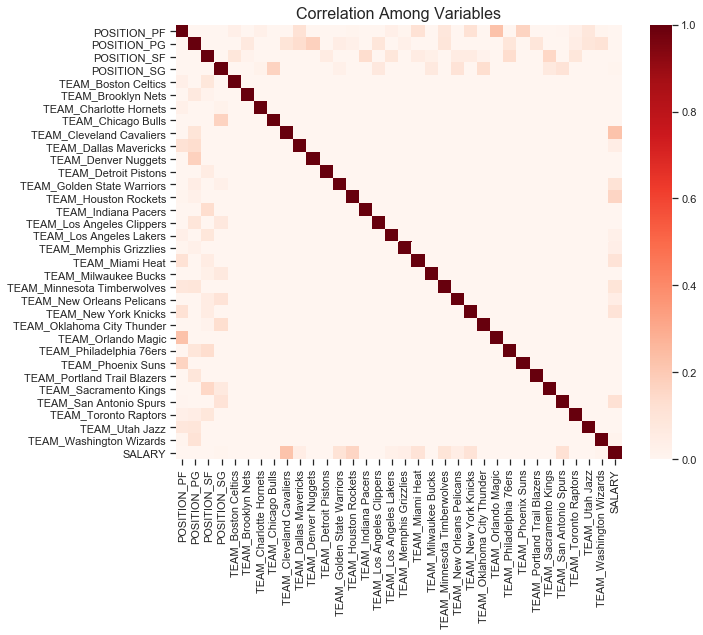

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Reds')
plt.title('Correlation Among Variables', fontsize=16)

In [40]:
print(abs(temp.corr()["SALARY"]).sort_values(ascending=False))

SALARY                         1.000000
TEAM_Cleveland Cavaliers       0.225236
TEAM_Brooklyn Nets             0.194550
TEAM_Houston Rockets           0.161096
TEAM_Los Angeles Clippers      0.139010
TEAM_Oklahoma City Thunder     0.126884
TEAM_San Antonio Spurs         0.119863
TEAM_Chicago Bulls             0.118384
TEAM_Golden State Warriors     0.110301
TEAM_New York Knicks           0.107711
TEAM_Boston Celtics            0.107521
TEAM_Miami Heat                0.107052
TEAM_Minnesota Timberwolves    0.098854
TEAM_Phoenix Suns              0.096951
TEAM_Detroit Pistons           0.080391
TEAM_Sacramento Kings          0.079023
TEAM_Utah Jazz                 0.074153
TEAM_Indiana Pacers            0.059490
POSITION_PF                    0.057057
POSITION_PG                    0.052200
TEAM_Orlando Magic             0.049814
TEAM_New Orleans Pelicans      0.048921
TEAM_Dallas Mavericks          0.047797
TEAM_Memphis Grizzlies         0.042341
TEAM_Denver Nuggets            0.039313


## Feature engineering

In [41]:

def fe_target_var(df):
#     return pd.DataFrame(np.log(df["SALARY"]))
#     return pd.DataFrame(df["SALARY"])
    return pd.DataFrame(df["SALARY"]**(1/3))

def fe_numerical_var(df):

    df_number = normalized(df[col_number])
    for col in skew_high_cols:
        df_eda[col] = df_eda[col]** (1/3)
    
    for col in skew_medium_cols:
        df_number[col] = np.sqrt(df_number[col])

    for col in skew_low_log:
        df_number[col] = df_number[col] ** 2

    df_number.drop(columns=["Games","TRB", "ORB",
                            "DWS", "OWS"], axis=1, inplace=True)

    return df_number




def fe_categorical_var(df, cols):
    d = pd.DataFrame()
    for col in cols:
        dummies = pd.get_dummies(
            df[col], prefix_sep="_", drop_first=True, prefix=col)
        #df.drop(columns=col, inplace=True)
        d = pd.concat([d, dummies], axis=1)

    return d


def feature_eng(df):
    return pd.concat(
        [fe_target_var(df), fe_numerical_var(df), fe_categorical_var(df, col_category)], axis=1)

In [42]:
df_engineered = feature_eng(df)
df_engineered

SALARY       Age   Minutes       PER        TS       DRB       AST  \
0    1.355311  0.166667  0.650830  0.783493  0.743467  0.689132  0.340755   
1    1.345036  0.277778  0.423716  0.567258  0.519656  0.416828  0.795425   
2    2.314869  0.388889  0.706450  0.780327  0.675053  0.297998  0.924906   
3    1.144714  0.111111  0.037080  0.281439  0.000000  0.206085  0.658521   
4    1.418619  0.777778  0.100425  0.433727  0.569995  0.845154  0.137686   
5    1.077918  0.166667  0.000772  0.000000  0.243047  0.460820  0.228326   
6    1.846915  0.611111  0.718038  0.487467  0.468411  0.397871  0.698679   
7    2.494068  0.333333  0.642719  0.637135  0.629781  0.240655  0.586176   
8    2.289428  0.444444  0.953650  0.814473  0.714527  0.452364  0.878927   
9    1.526051  0.166667  0.682117  0.512227  0.671920  0.443747  0.307875   
10   1.843978  0.388889  0.835458  0.629317  0.808708  0.164399  0.389434   
11   1.643593  0.500000  0.379683  0.754524  0.668773  0.829011  0.380197   
12   2.351335  0.666667  0.450753  0.700071  0.595341  0.654654  0.580080   
13   1.791158  0.722222  0.778293  0.580201  0.934568  0.489267  0.515173   
14   2.512046  0.222222  0.999228  0.796030  0.573685  0.460820  0.953914   
15   1.293689  0.166667  0.388953  0.648685  0.649570  0.697486  0.510552   
16   1.058446  0.388889  0.144844  0.344691  0.290496  0.680676  0.194717   
17   1.618062  0.222222  0.982619  0.767534  0.717473  0.340338  0.738257   
18   2.136786  0.555556  0.339127  0.696526  0.729140  0.743050  0.435400   
19   1.335247  0.277778  0.301661  0.398015  0.425951  0.716599  0.182141   
20   2.817214  0.500000  0.773658  0.850160  0.806095  0.915335  0.413057   
21   1.957434  0.666667  0.610660  0.605257  0.746299  0.541698  0.580080   
22   1.734604  0.500000  0.547316  0.678525  0.705613  0.270849  0.404360   
23   1.587401  0.166667  0.551178  0.487467  0.573685  0.608816  0.248216   
24   1.866256  0.444444  0.037852  0.385376  0.297670  0.713900  0.429923   
25   1.952966  0.777778  0.575898  0.789786  0.566282  0.872134  0.627188   
26   1.650964  0.777778  0.846273  0.540444  0.659241  0.512395  0.491636   
27   1.493802  0.333333  0.420626  0.652490  0.690502  0.651698  0.401419   
28   2.498250  0.444444  0.778679  0.580201  0.472894  0.582897  0.311699   
29   1.289616  0.166667  0.452298  0.540444  0.450035  0.362318  1.000000   
..        ...       ...       ...       ...       ...       ...       ...   
90   1.411805  0.944444  0.446891  0.811428  0.779484  0.473221  0.798399   
91   1.131640  0.777778  0.396292  0.521802  0.527713  0.639739  0.421575   
92   1.096961  0.388889  0.242178  0.306691  0.435745  0.504803  0.337260   
93   1.553616  0.222222  0.307068  0.696526  0.580993  0.856499  0.456652   
94   1.418619  0.777778  0.665508  0.450522  0.450035  0.297998  0.696981   
95   1.338687  0.166667  0.780610  0.660033  0.378761  0.602440  0.816013   
96   2.700274  0.333333  0.928544  1.000000  0.782186  0.948480  0.676274   
97   2.314782  0.444444  0.825801  0.757798  0.629781  0.576235  0.555029   
98   2.381102  0.555556  0.834299  0.889988  0.602386  0.923733  0.503542   
99   1.005114  0.277778  0.740054  0.455983  0.595341  0.460820  0.429923   
100  1.650964  0.333333  0.750869  0.502469  0.734904  0.340338  0.248216   
101  1.709976  0.388889  0.134415  0.575919  0.743467  0.711190  0.367520   
102  1.777234  0.444444  0.681344  0.487467  0.782186  0.388045  0.330159   
103  1.709976  0.888889  0.387408  0.764303  1.000000  0.773599  0.000000   
104  1.267893  0.166667  0.143299  0.410264  0.633122  0.477283  0.257586   
105  2.248693  0.333333  0.947470  0.928109  0.831855  0.425990  0.946433   
106  1.426043  0.777778  0.388567  0.575919  0.498944  0.814919  0.443489   
107  1.310371  0.555556  0.449594  0.535844  0.551178  0.138943  0.708780   
108  1.783701  0.500000  0.610274  0.592862  0.734904  0.356950  0.413057   
109  2.289428  0.222222  0.857860  0.707107  0.472894  0.456612  0.808720   
110

In [43]:
# selected_features = []

## Modelling

In [44]:
X_train = df_engineered.iloc[:,1:]
y_train = df_engineered["SALARY"]

In [45]:
# df_engineered.columns

In [46]:
df_test = feature_eng(pd.read_csv("NBA_Test.csv"))
df_test['TEAM_Houston Rockets'] = 0
df_test = df_test[df_engineered.columns]

X_test = df_test.iloc[:,1:]
y_test = df_test["SALARY"]

### Lasso

In [47]:
alpha = list(np.logspace(-4, -.5, 30))

lasso = LassoCV(cv=5, random_state=0, alphas=alpha)

lasso.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.00013203517797162948, 0.00017433288221999874,
                0.00023018073130224678, 0.0003039195382313198,
                0.0004012807031942776, 0.0005298316906283707,
                0.0006995642156712634, 0.0009236708571873865,
                0.0012195704601594415, 0.0016102620275609393,
                0.0021261123338996556, 0.0028072162039411755,
                0.0037065129109221566, 0.004893900918477494,
                0.006461670787466...
                0.02592943797404667, 0.03423597957607583, 0.04520353656360245,
                0.05968456995122311, 0.07880462815669913, 0.10404983103657853,
                0.1373823795883264, 0.1813930693911063, 0.2395026619987486,
                0.31622776601683794],
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
        verbose=False)

In [48]:
lasso.alpha_

0.011264816923358867

In [49]:
lasso.coef_

array([ 0.        ,  0.65824854,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.47699075,
        0.        , -0.14983528,  0.27756787, -0.        , -0.05618891,
       -0.        , -0.        , -0.        , -0.00300209, -0.        ,
       -0.03431591,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ])

In [50]:
y_pred = lasso.predict(X_test)

In [51]:
# np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
# np.sqrt(mean_squared_error(y_test, y_pred))
np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))

4.357051470967911

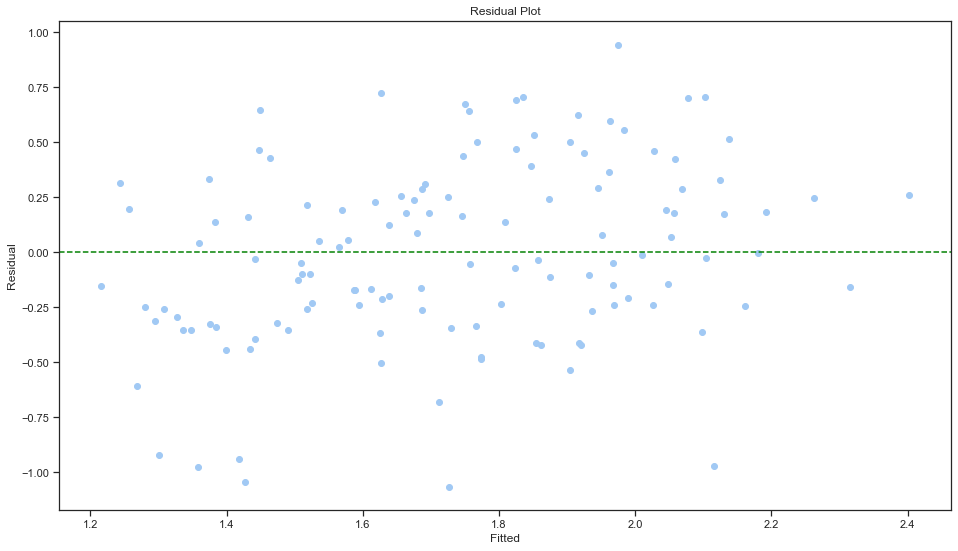

In [52]:
def plot_resid(y_test, y_pred):
    """

    """

    resid = y_test-y_pred

    plt.figure(figsize=(16, 9))
    plt.scatter(y_pred, resid)
    plt.axhline(0, 0, 1, color="g", ls="--")
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual Plot")
    plt.savefig("Residual plot ols")
    plt.show()


plot_resid(y_test, y_pred)

### Gradient Boosting

In [92]:
tuning_parameters = {
    'learning_rate': [0.01,0.02,0.03,0.04,0.05, 0.1],
    'n_estimators': [250,350,500],
    'max_depth': [2, 3, 4],
    'subsample': np.arange(0.1,1,0.1)
}

# Using GridSearchCV would be too slow. Increase the number of iterations to explore more hyperparameter combinations.
gb = RandomizedSearchCV(GradientBoostingRegressor(
), tuning_parameters, n_iter=1, cv=10, return_train_score=False, n_jobs=4)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.2, 'n_estimators': 350, 'max_depth': 2, 'learning_rate': 0.01} 



In [93]:
# np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))
# np.sqrt(mean_squared_error(y_test, y_pred))
np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))

4.042203625277661

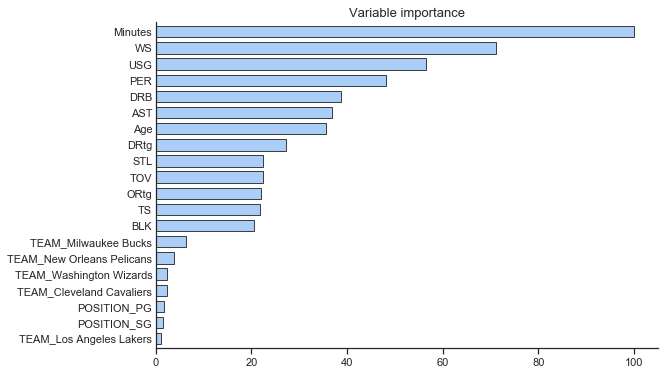

In [94]:
plot_feature_importance(gb.best_estimator_, list(X_train))
plt.show()

### RandomForestRegressor

In [56]:
tuning_parameters = {
#     'min_samples_leaf': [1, 5, 10, 20, 50],
#     'max_features': np.arange(1, X_train.shape[1], 5),
    
    'n_estimators': np.arange(1, 200, 5),
    'max_depth': np.arange(1, 40, 2),
    "max_features": np.arange(0.2, 0.5, 0.1),
}

rf_search = RandomizedSearchCV(RandomForestRegressor(), tuning_parameters, cv=10, n_iter=20, return_train_score=True, n_jobs=4,
                               random_state=20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

y_pred = rf.predict(X_test)

np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))



Best parameters found by randomised search: {'min_samples_leaf': 10, 'max_features': 16} 



4.357830606681038

In [112]:
para = {    
'n_estimators': np.arange(1, 100, 5),
    'max_depth': np.arange(11, 17, 2),
    "max_features": np.arange(0.2, 0.5, 0.02),
       }
report = []

def rmse(y_pred1, y_test):
    return np.sqrt(((y_pred1 - y_test) ** 2).mean())
i = 0

for n in np.arange(65, 75, 1):
    for md in np.arange(11, 17, 2):
        for mf in np.arange(0.2, 0.5, 0.02): 
            print(i)
            print((n,md,mf))
            xgb_model = RandomForestRegressor(n_estimators=n ,max_depth=md,max_features=mf)
            xgb_model.fit(X_train,y_train)
            y_pred1 = xgb_model.predict(X_test)

            report.append(rmse(y_pred1,y_test).round(4))
            i += 1
report

0
(65, 11, 0.2)
1
(65, 11, 0.22)
2
(65, 11, 0.24)
3
(65, 11, 0.26)
4
(65, 11, 0.27999999999999997)
5
(65, 11, 0.29999999999999993)
6
(65, 11, 0.31999999999999995)
7
(65, 11, 0.33999999999999997)
8
(65, 11, 0.35999999999999993)
9
(65, 11, 0.3799999999999999)
10
(65, 11, 0.3999999999999999)
11
(65, 11, 0.41999999999999993)
12
(65, 11, 0.4399999999999999)
13
(65, 11, 0.4599999999999999)
14
(65, 11, 0.47999999999999987)
15
(65, 13, 0.2)
16
(65, 13, 0.22)
17
(65, 13, 0.24)
18
(65, 13, 0.26)
19
(65, 13, 0.27999999999999997)
20
(65, 13, 0.29999999999999993)
21
(65, 13, 0.31999999999999995)
22
(65, 13, 0.33999999999999997)
23
(65, 13, 0.35999999999999993)
24
(65, 13, 0.3799999999999999)
25
(65, 13, 0.3999999999999999)
26
(65, 13, 0.41999999999999993)
27
(65, 13, 0.4399999999999999)
28
(65, 13, 0.4599999999999999)
29
(65, 13, 0.47999999999999987)
30
(65, 15, 0.2)
31
(65, 15, 0.22)
32
(65, 15, 0.24)
33
(65, 15, 0.26)
34
(65, 15, 0.27999999999999997)
35
(65, 15, 0.29999999999999993)
36
(65, 15, 0

284
(71, 11, 0.47999999999999987)
285
(71, 13, 0.2)
286
(71, 13, 0.22)
287
(71, 13, 0.24)
288
(71, 13, 0.26)
289
(71, 13, 0.27999999999999997)
290
(71, 13, 0.29999999999999993)
291
(71, 13, 0.31999999999999995)
292
(71, 13, 0.33999999999999997)
293
(71, 13, 0.35999999999999993)
294
(71, 13, 0.3799999999999999)
295
(71, 13, 0.3999999999999999)
296
(71, 13, 0.41999999999999993)
297
(71, 13, 0.4399999999999999)
298
(71, 13, 0.4599999999999999)
299
(71, 13, 0.47999999999999987)
300
(71, 15, 0.2)
301
(71, 15, 0.22)
302
(71, 15, 0.24)
303
(71, 15, 0.26)
304
(71, 15, 0.27999999999999997)
305
(71, 15, 0.29999999999999993)
306
(71, 15, 0.31999999999999995)
307
(71, 15, 0.33999999999999997)
308
(71, 15, 0.35999999999999993)
309
(71, 15, 0.3799999999999999)
310
(71, 15, 0.3999999999999999)
311
(71, 15, 0.41999999999999993)
312
(71, 15, 0.4399999999999999)
313
(71, 15, 0.4599999999999999)
314
(71, 15, 0.47999999999999987)
315
(72, 11, 0.2)
316
(72, 11, 0.22)
317
(72, 11, 0.24)
318
(72, 11, 0.26)
3

[0.4314,
 0.4385,
 0.4333,
 0.4231,
 0.4245,
 0.4334,
 0.422,
 0.4189,
 0.4241,
 0.4307,
 0.4276,
 0.4214,
 0.4232,
 0.4193,
 0.4176,
 0.4256,
 0.4294,
 0.4328,
 0.4314,
 0.424,
 0.4234,
 0.4211,
 0.4266,
 0.4234,
 0.4269,
 0.4184,
 0.417,
 0.426,
 0.4215,
 0.4246,
 0.4257,
 0.4269,
 0.4285,
 0.4214,
 0.4315,
 0.4265,
 0.4129,
 0.4188,
 0.4265,
 0.4248,
 0.4209,
 0.4236,
 0.4181,
 0.4228,
 0.4229,
 0.4253,
 0.4292,
 0.4232,
 0.4277,
 0.4258,
 0.4167,
 0.4202,
 0.4177,
 0.4217,
 0.4186,
 0.4217,
 0.4197,
 0.4169,
 0.4183,
 0.4332,
 0.4308,
 0.4189,
 0.4297,
 0.425,
 0.4266,
 0.4242,
 0.421,
 0.4255,
 0.4275,
 0.4299,
 0.418,
 0.4336,
 0.4306,
 0.4334,
 0.4146,
 0.4318,
 0.4344,
 0.4298,
 0.4256,
 0.4255,
 0.4284,
 0.4234,
 0.4256,
 0.4267,
 0.4244,
 0.4265,
 0.4198,
 0.4317,
 0.426,
 0.4245,
 0.4282,
 0.4372,
 0.4195,
 0.4258,
 0.432,
 0.4214,
 0.4228,
 0.4259,
 0.4238,
 0.4176,
 0.4253,
 0.4198,
 0.4221,
 0.4292,
 0.4281,
 0.4245,
 0.4246,
 0.4221,
 0.4258,
 0.4211,
 0.4262,
 0.4295,
 

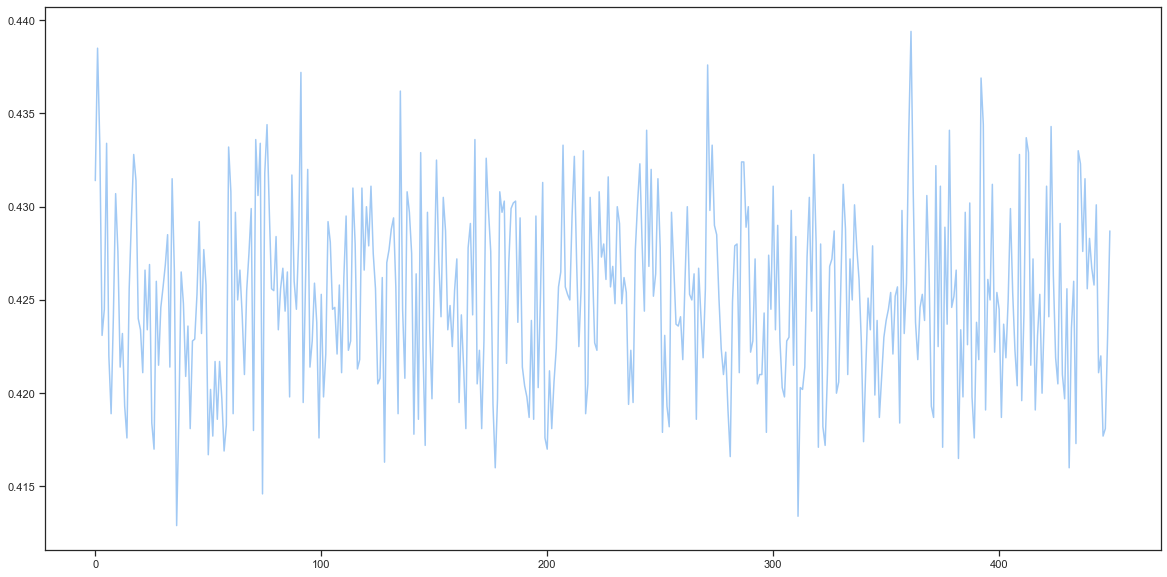

In [113]:
plt.figure(figsize=(20,10))
plt.plot(report)

In [114]:
np.argsort(report)

array([ 36, 311,  74, 177, 431, 128, 382, 281,  50,  57, 200,  26, 375,
       320, 146, 323, 434, 340, 199,  14, 389,  99,  52, 446, 141, 251,
       297,  70, 202,  42, 164, 171, 447, 254, 322,  58,  25, 356, 143,
        54, 194, 266, 371, 192, 347, 401,  37, 134, 217,  61,   7, 394,
       416, 280,  13, 370, 253, 176, 236,  92, 238, 161, 410,  56, 178,
       429, 149, 101, 191, 305,  86, 384, 388, 345, 328, 419, 313,  51,
       304, 196, 312, 408, 190, 218, 125, 293, 169, 426, 203, 329, 137,
       126, 348,  40, 295, 278, 333, 294, 324, 428,  66,  21, 109, 444,
       285, 201, 116, 163,  95, 341, 314,  33,  11, 189, 414,  28, 309,
       182,  55,  53, 260, 364, 391, 117, 269, 425, 403, 445,   6, 107,
       353, 102, 290, 279, 398, 222, 237, 170, 112, 407, 204, 277, 373,
       214, 145, 158, 386, 221, 291, 339, 172,  96, 303, 113,  43, 306,
        44, 349, 448, 307,   3, 252, 417, 358,  47,  12, 301, 156,  23,
       148, 383,  20,  81, 343, 432, 258,  41, 257, 377, 402, 39

In [115]:
np.sort(report)

array([0.4129, 0.4134, 0.4146, 0.416 , 0.416 , 0.4163, 0.4165, 0.4166,
       0.4167, 0.4169, 0.417 , 0.417 , 0.4171, 0.4171, 0.4172, 0.4172,
       0.4173, 0.4174, 0.4176, 0.4176, 0.4176, 0.4176, 0.4177, 0.4177,
       0.4178, 0.4179, 0.4179, 0.418 , 0.4181, 0.4181, 0.4181, 0.4181,
       0.4181, 0.4182, 0.4182, 0.4183, 0.4184, 0.4184, 0.4186, 0.4186,
       0.4186, 0.4186, 0.4187, 0.4187, 0.4187, 0.4187, 0.4188, 0.4189,
       0.4189, 0.4189, 0.4189, 0.4191, 0.4191, 0.4191, 0.4193, 0.4193,
       0.4193, 0.4194, 0.4194, 0.4195, 0.4195, 0.4195, 0.4196, 0.4197,
       0.4197, 0.4197, 0.4197, 0.4198, 0.4198, 0.4198, 0.4198, 0.4198,
       0.4198, 0.4199, 0.42  , 0.42  , 0.4202, 0.4202, 0.4203, 0.4203,
       0.4203, 0.4204, 0.4204, 0.4205, 0.4205, 0.4205, 0.4205, 0.4205,
       0.4206, 0.4206, 0.4208, 0.4208, 0.4208, 0.4209, 0.421 , 0.421 ,
       0.421 , 0.421 , 0.421 , 0.421 , 0.421 , 0.4211, 0.4211, 0.4211,
       0.4211, 0.4212, 0.4213, 0.4214, 0.4214, 0.4214, 0.4214, 0.4214,
      

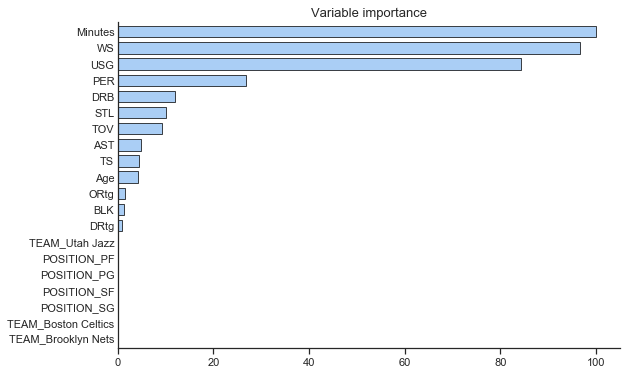

In [57]:
plot_feature_importance(rf_search.best_estimator_, list(X_train))
plt.show()

### Xgboost

In [58]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
reg_xgb = GridSearchCV(xgb_model,
                       {'max_depth': [2, 4, 6],
                        'n_estimators': [50, 100, 200]}, verbose=1)
reg_xgb.fit(X_train, y_train)

print(reg_xgb.best_score_)

print('Best parameters found by randomised search:', reg_xgb.best_params_, '\n')

y_pred = reg_xgb.predict(X_test)

np.sqrt(mean_squared_error(y_test ** 3, y_pred**3))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.3320053305424023
Best parameters found by randomised search: {'max_depth': 2, 'n_estimators': 50} 



[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.5s finished


4.036398435677304

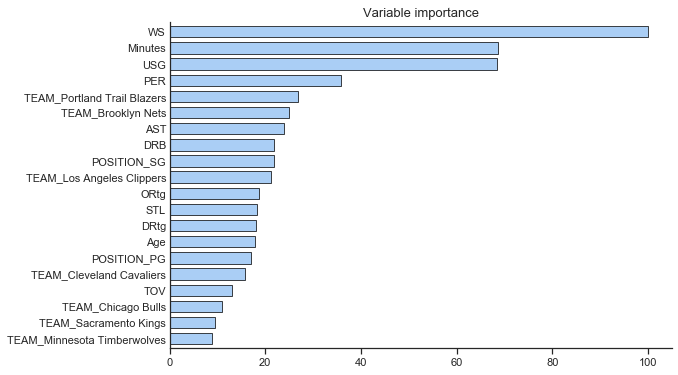

In [59]:
plot_feature_importance(reg_xgb.best_estimator_, list(X_train))
plt.show()

In [60]:
toc = time.time()
print("Training time: {0:.4f}s".format(toc - tic))

Training time: 47.6690s
